# P6: ENT-icipate
**Goal**: Predicting Surgical Complications for patients who underwent a tumor removal surgery in Ear-Nose-Throat (ENT) area (project in collaboration with **Hospital Molinette** and supervised by **Links Foundation**)

## Why This Matters
Surgery for Ear, Nose, and Throat (ENT) cancers is complex and carries significant risks. Some patients experience serious post-operative complications, such as tissue breakdown (fistula) or hospital-acquired infections. Predicting which patients are at higher risk using preoperative and perioperative data can help surgeons intervene early, personalize post-operative care, and allow hospital managers to allocate resources more effectively.
This project is supervised by LINKS Foundation in collaboration with the ENT Ward of Molinette Hospital and focuses on providing actionable, clinically relevant predictions to improve patient safety and operational planning.

---

## What We're Trying to Do

We are developing machine learning models to predict two major post-surgery complications:
- **Fistula** (when tissue breaks down and creates an abnormal opening) - happens in about 8% of patients
- **Infection** (nosocomial infection acquired in the hospital) - happens in about 24% of patients

We use patient data collected before and during surgery—such as age, comorbidities, TNM staging, and type of procedure—to train models that can reliably predict these outcomes. The dataset includes 574 patients who underwent ENT tumor removal surgery between 2002 and 2023, with manually collected clinical and surgical records approved for research by the hospital’s Ethics Committee.

Because these complications are relatively rare, careful model design and evaluation are critical.
Standard accuracy metrics are insufficient—for instance, always predicting “no complication” would yield high accuracy for fistulas but would be clinically meaningless. Our models are designed to prioritize high recall, ensuring that high-risk patients are correctly identified for early intervention and personalized post-operative management, but also tried to minimize the number of false alarms.

---
Our workflow will include:

-Data exploration and preprocessing, including feature selection and handling heterogeneous clinical variables.

-Training and validation of machine learning models for prediction of complications.

-Comparison of different models on the validation set

-Model evaluation with metrics suitable for imbalanced outcomes (high recall prioritized to avoid missing high-risk patients).



# Section 1: Data Loading and Initial Exploration

First, we load the data from the Excel file. The dataset has some quirks - the column names are spread across multiple rows, so we need to clean that up first. Once we load it, we should have around 577 patient records before we start removing data with missing values.

Let's start by loading the data and taking a quick look at what we're working with.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Load the dataset
df = pd.read_excel("Dataset_ENTicipate.xlsx")

# Feature names is sometimes in all 3 first lines sometime only in the second line
new_columns = []
for col_idx, col_name in enumerate(df.columns):
    if "Unnamed" in str(col_name) or col_name is None:
        # Substitute with value in line 0
        new_columns.append(str(df.iloc[0, col_idx]))
    else:
        new_columns.append(col_name)

# Update the columns name
df.columns = new_columns

df = df.drop(index=[0,1]).reset_index(drop=True)
df.columns = df.columns.str.replace('\n', '', regex=True)

df.rename(columns={
    'Type of surgical procedure (1 partial glossectomy, 2 hemiglossectomy, 3 subtotal/total glossectomy, 4 commando, 5 pharyngectomy, 6 cordectomy, 7 partial laryngectomy, 8 total laryngectomy, 9 PAROTID GLANDctomy, 10 emptying only, 11 thyroidectomy, 12 rhinectomy, 13 maxillectomy, 14 lip excision, 15 ear excision, 16 pharyngolaryngectomy, 17 pharyngoglossectomy, 18 pelvectomy, 19 other procedures)': 'Type of surgical procedure',
}, inplace=True)

print("✓ Dataset loaded successfully")
print(f"Shape: {df.shape}")
df.head()

✓ Dataset loaded successfully
Shape: (574, 64)


,ID,Site,Site ID,Sex (0: male; 1: female),Age > 65 years old,Age at diagnosis,Weight (Kg),Usual weight (maintained for at least 6 months),Weight loss (kg),Significant weight loss? (0: no; 1: yes),...,Wound dehiscence,Pulmonary thromboembolism,Complete necrosis of the flap,Partial necrosis of the flap,Necrosis (overall),Other complications,Hypertensive crisis,Any complication,Score Clavien-Dindo (tenere conto della complicanza peggiore),Nosocomial infection
0,1.0,LARYNX,4,0.0,0,64.0,75.0,75.0,0.0,0,...,0.0,0.0,0.0,0.0,0,1.0,0,1,I,0.0
1,2.0,HYPOPHARYNX,5,0.0,0,61.0,70.0,70.0,0.0,0,...,0.0,0.0,0.0,0.0,0,1.0,0,1,IIIB,1.0
2,3.0,LARYNX,4,0.0,0,54.0,112.0,112.0,0.0,0,...,0.0,0.0,0.0,0.0,0,1.0,0,1,II,0.0
3,4.0,LARYNX,4,0.0,1,66.0,72.0,72.0,0.0,0,...,0.0,0.0,0.0,0.0,0,0.0,0,1,II,1.0
4,5.0,UNKNOWN FOCUS,7,0.0,0,61.0,75.0,75.0,0.0,0,...,0.0,0.0,0.0,0.0,0,1.0,0,1,I,0.0


In [ ]:
# 2.1 Dataset Structure Overview
print("=" * 80)
print("DATASET INFORMATION")
print("=" * 80)
print(df.info())

print("\n" + "=" * 80)
print("DESCRIPTIVE STATISTICS")
print("=" * 80)
print(df.describe())

print("\n" + "=" * 80)
print("UNIQUE VALUES")
print("=" * 80)
for col in df.columns:
    print(f"\n--- {col} ---")
    print(df[col].unique())

DATASET INFORMATION
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 574 entries, 0 to 573
Data columns (total 64 columns):
 #   Column                                                         Non-Null Count  Dtype  
---  ------                                                         --------------  -----  
 0   ID                                                             574 non-null    float64
 1   Site                                                           574 non-null    object 
 2   Site ID                                                        574 non-null    object 
 3   Sex (0: male; 1: female)                                       574 non-null    float64
 4   Age > 65 years old                                             574 non-null    object 
 5   Age at diagnosis                                               574 non-null    float64
 6   Weight (Kg)                                                    574 non-null    float64
 7   Usual weight (maintained for at least 6 mo

## Understanding the Data Structure

Now let's get a better sense of the dataset. We need to see what types of variables we have (numerical vs categorical), how much missing data there is, and what the descriptive statistics look like. This will help us plan our preprocessing steps.

In [2]:
# 2.2 Data Cleaning - Standardize Inconsistencies
print("\n" + "=" * 80)
print("DATA CLEANING: Standardizing Inconsistent Values")
print("=" * 80)

# Standardize target variables
df['Pharyngo-/oro-cutaneous fistula'] = df['Pharyngo-/oro-cutaneous fistula'].replace(
    {'fistola oro-cutanea 24/4 per cedimento delle suture endorali': 1}
)
df['Diabetes'] = df['Diabetes'].replace({'intolleranza glucidica modesta': 1}).astype(float)

print("✓ Target variables standardized")


DATA CLEANING: Standardizing Inconsistent Values
✓ Target variables standardized


/tmp/ipython-input-2911940861.py:7: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['Pharyngo-/oro-cutaneous fistula'] = df['Pharyngo-/oro-cutaneous fistula'].replace(
/tmp/ipython-input-2911940861.py:10: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['Diabetes'] = df['Diabetes'].replace({'intolleranza glucidica modesta': 1}).astype(float)


## Cleaning Up Messy Data

The dataset has some inconsistencies. For example, some values in target columns are written as text instead of numbers (like "fistola oro-cutanea..." instead of just 1). We need to fix these before we can use the data properly. Once we clean these up, we can look at the distribution of complications.


TARGET VARIABLE DISTRIBUTIONS


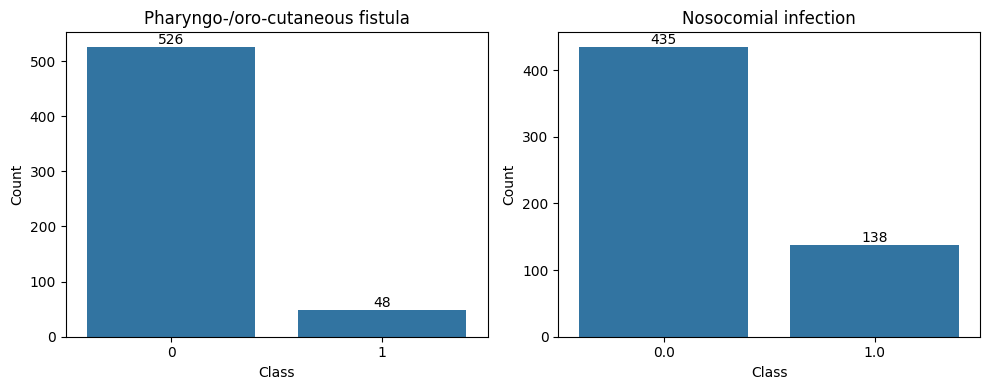


Fistula - Positive: 48 (8.4%)
Infection - Positive: 138.0 (24.0%)


In [3]:
# 2.3 Target Variable Distribution Analysis
print("\n" + "=" * 80)
print("TARGET VARIABLE DISTRIBUTIONS")
print("=" * 80)

target_columns = ['Pharyngo-/oro-cutaneous fistula', 'Nosocomial infection']

fig, axes = plt.subplots(1, 2, figsize=(10,4))

for idx, target in enumerate(target_columns):
  sns.countplot(data=df, x=target, ax=axes[idx])
  axes[idx].set_title(f"{target}")
  axes[idx].set_ylabel("Count")
  axes[idx].set_xlabel("Class")
  for p in axes[idx].patches:
        height = p.get_height()
        axes[idx].annotate(f'{int(height)}',
                          (p.get_x() + p.get_width() / 2., height),
                          ha='center', va='bottom')

plt.tight_layout()
plt.show()

print(f"\nFistula - Positive: {df[target_columns[0]].sum()} ({100*df[target_columns[0]].sum()/len(df):.1f}%)")
print(f"Infection - Positive: {df[target_columns[1]].sum()} ({100*df[target_columns[1]].sum()/len(df):.1f}%)")

## The Class Imbalance Problem

Now we can see the complications are imbalanced - most patients don't have complications. This is realistic but creates challenges for machine learning. A model that just predicts "no complication" for everyone would seem accurate but would miss all the positive cases we actually care about. We'll need to use appropriate metrics (like PR-AUC instead of regular accuracy) and techniques like class weighting to handle this properly.

# Section 2: Data Preprocessing & Cleaning

## 2.1 Feature Engineering - TNM Staging Encoding

Convert TNM staging variables from categorical/roman numerals to numerical codes.

In [4]:
import re, numpy as np, pandas as pd

roman_map = {"iv": "4", "iii": "3", "ii": "2", "i": "1"}

def to_0_4(v, kind=None):
    if pd.isna(v):
        return np.nan
    s = str(v).strip().lower()

    # remove T/N prefixes
    s = re.sub(r'^[tn]\s*', '', s)

    # x = not assessable
    if s == "x":
        return np.nan

    # special case: Tis
    if kind == "T" and s == "is":
        return 1

    # Roman numerals (typically for Stage, but harmless elsewhere)
    for r, a in roman_map.items():
        if s.startswith(r):
            s = a + s[len(r):]
            break

    m = re.match(r'^([0-4])', s)   # take only the first digit
    return int(m.group(1)) if m else np.nan

df["T"] = df["T"].apply(lambda v: to_0_4(v, kind="T"))
df["N"] = df["N"].apply(lambda v: to_0_4(v, kind="N"))
df["Stage"] = df["Stage"].apply(lambda v: to_0_4(v, kind="Stage"))


## 2.2 Data Type Standardization & Feature Selection

In [5]:
# 2.2a Data Type Standardization
print("\n" + "=" * 80)
print("DATA TYPE STANDARDIZATION & FEATURE SELECTION")
print("=" * 80)

# Transform object type columns into numerical type
cols = ["Age > 65 years old","Significant weight loss? (0: no; 1: yes)","Vascular comorbidities", "High blood pressure"]
df[cols] = df[cols].apply(pd.to_numeric, errors="coerce")

# Numerical columns but in reality they are categorical
cat_cols = [
    "Type of surgical procedure", "Smoking (0: no; 1: yes; 2: ex)",
    "Alcohol (0: no; 1: yes, 2: ex)", "Type of surgery (1=clean, 2=clean-contaminated)","0: normal weight; 1: underweight; 2: overweight"
]
df[cat_cols] = df[cat_cols].astype("object")

print(f"✓ Standardized {len(cols)} numeric columns")
print(f"✓ Classified {len(cat_cols)} categorical columns")


DATA TYPE STANDARDIZATION & FEATURE SELECTION
✓ Standardized 4 numeric columns
✓ Classified 5 categorical columns


## 2.2b Exploratory Correlation Analysis - Identifying Redundant Features

Before we decide which features to keep, let's look at the correlation matrix to identify redundant or highly correlated features. Some features might be measuring the same thing (like ASA score and Divided ASA score), so we should keep only one to avoid multicollinearity.


MULTICOLLINEARITY ASSESSMENT (Full Dataset)


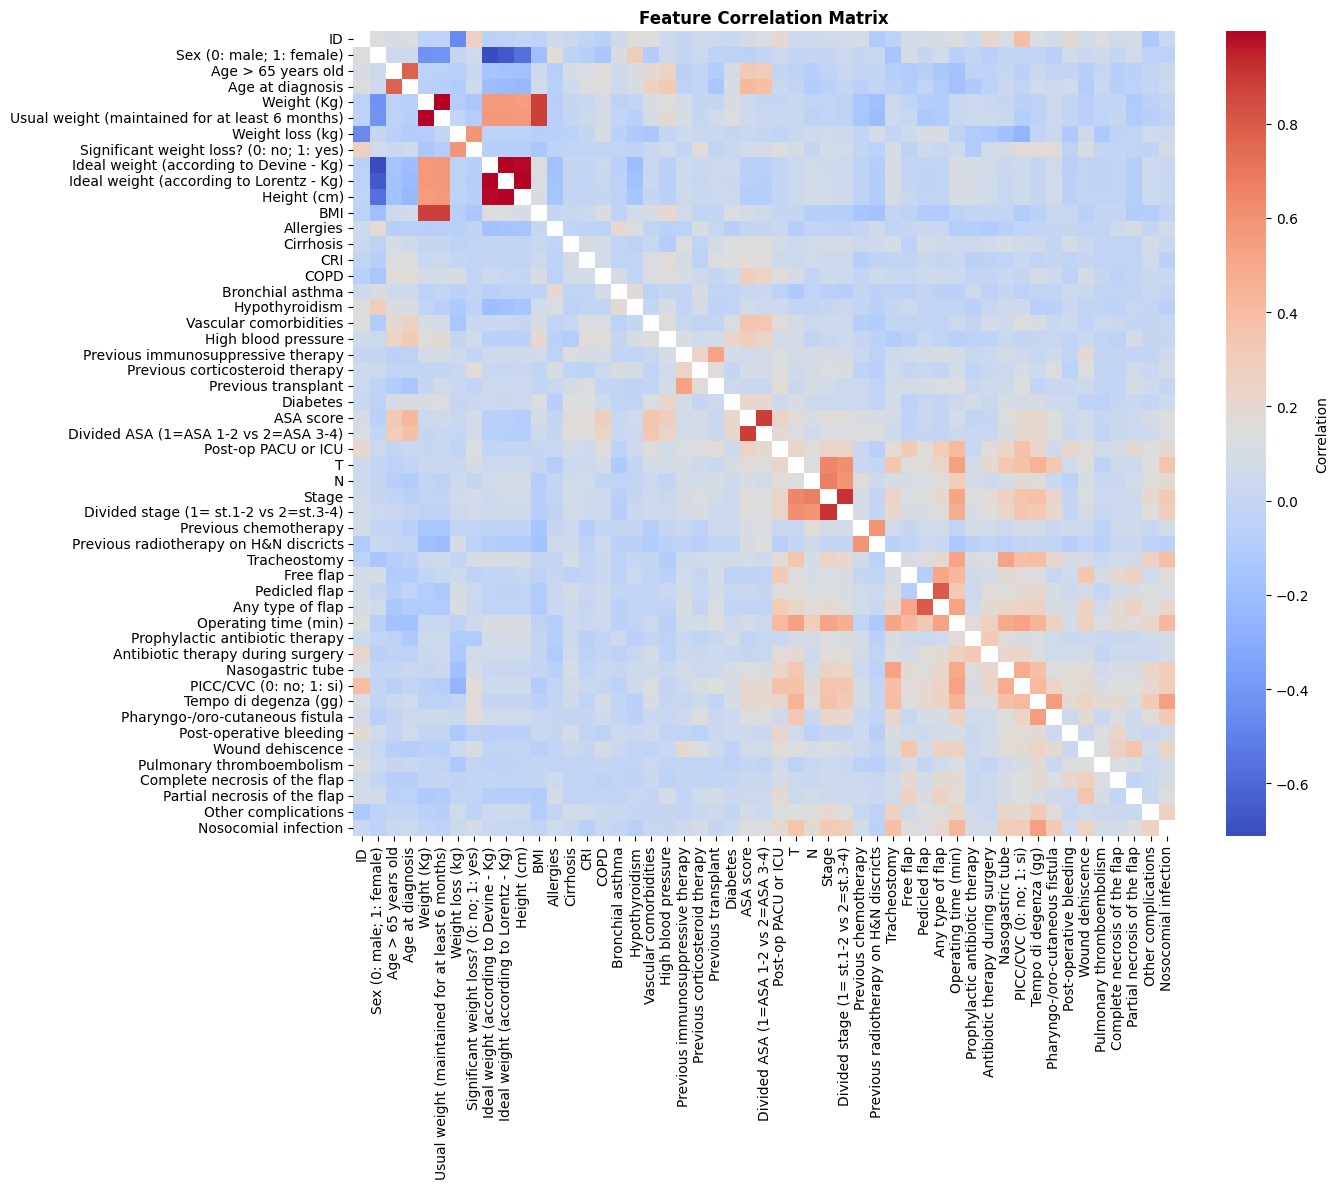

In [6]:
print("\n" + "=" * 80)
print("MULTICOLLINEARITY ASSESSMENT (Full Dataset)")
print("=" * 80)

num_cols = df.select_dtypes(include=np.number).columns.tolist()
corr = df.corr(numeric_only=True)

# Remove self-correlations for clarity
corr_no_diag = corr.copy()
np.fill_diagonal(corr_no_diag.values, np.nan)

valid_vals = corr_no_diag.values[~np.isnan(corr_no_diag.values)]
vmin, vmax = valid_vals.min(), valid_vals.max()

plt.figure(figsize=(14, 12))
sns.heatmap(corr_no_diag, cmap='coolwarm', vmin=vmin, vmax=vmax, cbar_kws={'label': 'Correlation'})
plt.title('Feature Correlation Matrix', fontsize=12, fontweight='bold')
plt.tight_layout()
plt.show()

## 2.3 Removing Redundant Features Based on Correlation Analysis

Looking at the correlation matrix, we can see several features that are highly correlated with each other:
- **ASA score** and **Divided ASA** are nearly identical (r ≈ 0.99) - they're just two different ways of coding the same information
- **Stage** and **Divided stage** have very high correlation - same issue
- Other redundant features like ideal weight calculations, height, weight that are derived from BMI

Since these represent the same underlying information, keeping all of them would introduce multicollinearity without adding new information. We'll keep only one version of each and remove the redundant ones. We also remove non-target outcome variables that won't be used for prediction.

In [7]:
# 2.2b Drop Non-Target Outcomes & Redundant Features
nc_targets = ['Tempo di degenza (gg)','Score Clavien-Dindo (tenere conto della complicanza peggiore)',
              'Post-operative bleeding','Wound dehiscence','Pulmonary thromboembolism',
              'Complete necrosis of the flap','Partial necrosis of the flap','Necrosis (overall)',
              'Other complications','Hypertensive crisis','Any complication']
df = df.drop(columns=nc_targets)

# Drop derived/redundant features
columns_to_drop = ['ID','Site','Prophylactic antibiotic therapy (dosage)',
                   'Antibiotic therapy during surgery (dosage)','Ideal weight (according to Devine - Kg)',
                   'Age > 65 years old','Any type of flap','Height (cm)','Weight (Kg)',
                   'Divided ASA (1=ASA 1-2 vs 2=ASA 3-4)','Divided stage (1= st.1-2 vs 2=st.3-4)',
                   'Usual weight (maintained for at least 6 months)',
                   'Ideal weight (according to Lorentz - Kg)','Weight loss (kg)']
df = df.drop(columns=columns_to_drop, errors='ignore')

print(f"✓ Removed {len(nc_targets)} non-target outcomes")
print(f"✓ Removed {len(columns_to_drop)} redundant features")
print(f"  Remaining features: {df.shape[1]}")

✓ Removed 11 non-target outcomes
✓ Removed 14 redundant features
  Remaining features: 39


In [8]:
# 2.3 Handle Missing Values in Critical Features
print("\n" + "=" * 80)
print("MISSING VALUES HANDLING")
print("=" * 80)

# Drop rows with missing values in critical columns
critical_cols = ['N','T','Stage','Free flap','Operating time (min)',
                 'Prophylactic antibiotic therapy','Antibiotic therapy during surgery','Nasogastric tube']
df_before = len(df)
df = df.dropna(subset=critical_cols)
df = df.dropna(subset=target_columns)  # Drop rows with missing target values
df_after = len(df)

print(f"Removed {df_before - df_after} rows with missing critical values")
print(f"Remaining samples: {df_after}")

# Show remaining missing values
missing = df.isna().sum()
missing = missing[missing > 0]
if len(missing) > 0:
    print(f"\nRemaining missing values:\n{missing}")
else:
    print("✓ No missing values in critical features")


MISSING VALUES HANDLING
Removed 8 rows with missing critical values
Remaining samples: 566

Remaining missing values:
Significant weight loss? (0: no; 1: yes)    132
dtype: int64


In [ ]:
# 2.4 Final Dataset Summary
print("\n" + "=" * 80)
print("FINAL DATASET SUMMARY (After Preprocessing)")
print("=" * 80)
print(f"Shape: {df.shape}")
print(f"Samples: {len(df)} | Features: {df.shape[1] - len(target_columns)}")
print(f"Numeric features: {df.select_dtypes(include=np.number).shape[1] - len(target_columns)}")
print(f"Categorical features: {df.select_dtypes(include='object').shape[1]}")
print(f"Target variables: {len(target_columns)}")


FINAL DATASET SUMMARY (After Preprocessing)
Shape: (566, 39)
Samples: 566 | Features: 37
Numeric features: 31
Categorical features: 6
Target variables: 2


In [ ]:
print("Final shape of the dataset:", df.shape)

Final shape of the dataset: (566, 39)


# Section 3: Data Splitting & Stratification

## 3.1 Stratified Train/Validation/Test Split

Split data into 70% train, 15% validation, 15% test with stratification on both targets to maintain class balance.

In [9]:
# ============================================================================
# SECTION 3: DATA SPLITTING & STRATIFICATION
# ============================================================================

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.metrics import (
    make_scorer, f1_score, roc_auc_score, average_precision_score,
    precision_score, recall_score, matthews_corrcoef, confusion_matrix
)
from imblearn.pipeline import Pipeline as ImbPipeline

print("\n" + "=" * 80)
print("STRATIFIED TRAIN/VALIDATION/TEST SPLIT (70/15/15)")
print("=" * 80)

# 70% train, 30% temp
train_df, temp_df = train_test_split(
    df, test_size=0.3, random_state=42, stratify=df[target_columns]
)

# 15% val, 15% test (50-50 split of temp)
val_df, test_df = train_test_split(
    temp_df, test_size=0.5, random_state=42, stratify=temp_df[target_columns]
)

print(f"Train: {len(train_df)} samples | Val: {len(val_df)} samples | Test: {len(test_df)} samples")
print(f"Total: {len(df)} samples")

# Verify stratification
for target in target_columns:
    print(f"\n{target}:")
    print(f"  Train: {train_df[target].sum()} pos ({100*train_df[target].mean():.1f}%) | "
          f"Val: {val_df[target].sum()} pos ({100*val_df[target].mean():.1f}%) | "
          f"Test: {test_df[target].sum()}")



STRATIFIED TRAIN/VALIDATION/TEST SPLIT (70/15/15)
Train: 396 samples | Val: 85 samples | Test: 85 samples
Total: 566 samples

Pharyngo-/oro-cutaneous fistula:
  Train: 33 pos (8.3%) | Val: 7 pos (8.2%) | Test: 7

Nosocomial infection:
  Train: 96.0 pos (24.2%) | Val: 20.0 pos (23.5%) | Test: 21.0



Missing value patterns in training set:


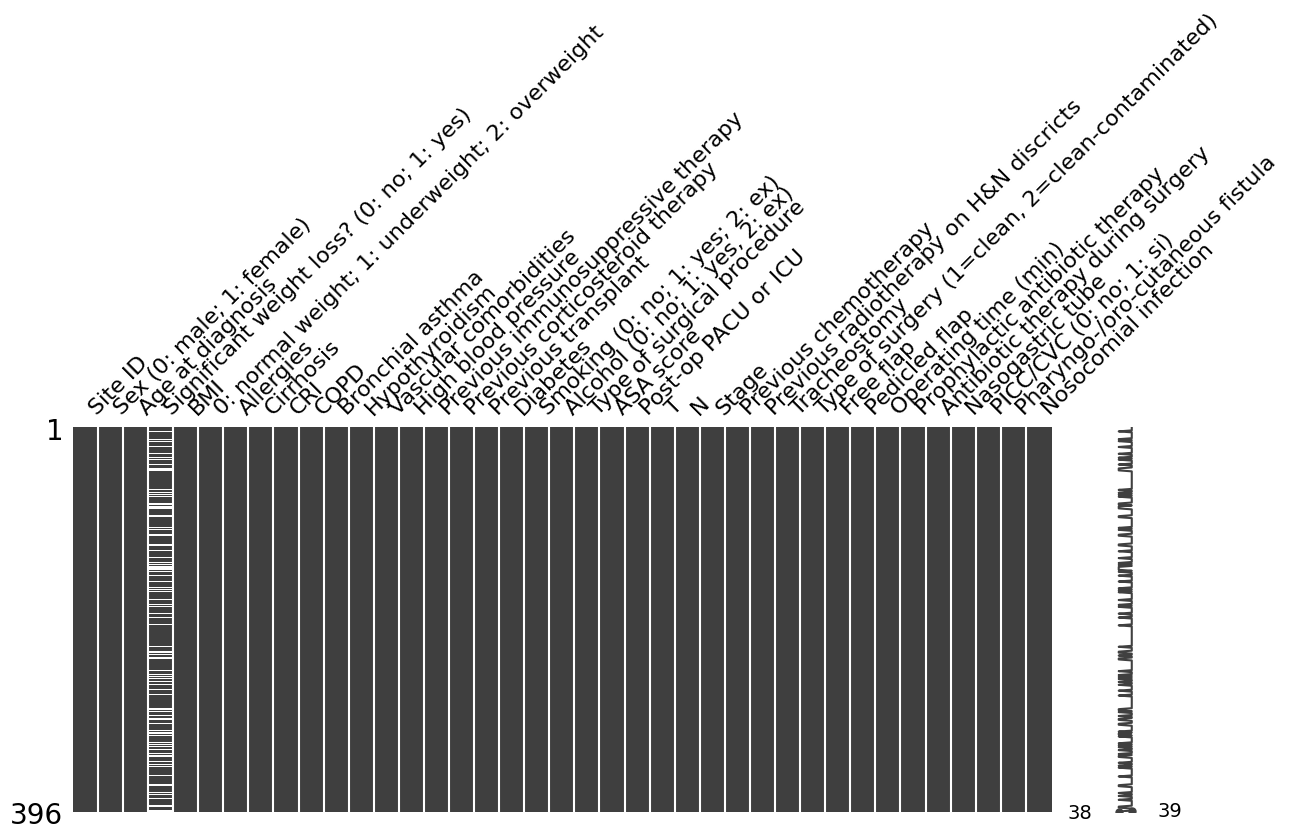

In [ ]:
# 3.2 Missing Value Visualization in Train Split
import missingno as msno

print("\nMissing value patterns in training set:")
msno.matrix(train_df, figsize=(14, 5))
plt.show()

In [10]:
# 3.3 Imputation of missing values
from sklearn.impute import SimpleImputer

col = "Significant weight loss? (0: no; 1: yes)"

# Coerce to numeric, then to object for categorical imputation
train_df[col] = pd.to_numeric(train_df[col], errors='coerce').astype('object')
val_df[col] = pd.to_numeric(val_df[col], errors='coerce').astype('object')
test_df[col] = pd.to_numeric(test_df[col], errors='coerce').astype('object')

# Fit imputer on train, apply to all splits
imputer = SimpleImputer(strategy="constant", fill_value='-1')
train_df[[col]] = imputer.fit_transform(train_df[[col]])
val_df[[col]] = imputer.transform(val_df[[col]])
test_df[[col]] = imputer.transform(test_df[[col]])

# Ensure string type for OneHotEncoder compatibility
for split_df in [train_df, val_df, test_df]:
    split_df[col] = split_df[col].astype(str)


In [ ]:
train_df.describe()

,Sex (0: male; 1: female),Age at diagnosis,BMI,Allergies,Cirrhosis,CRI,COPD,Bronchial asthma,Hypothyroidism,Vascular comorbidities,...,Tracheostomy,Free flap,Pedicled flap,Operating time (min),Prophylactic antibiotic therapy,Antibiotic therapy during surgery,Nasogastric tube,PICC/CVC (0: no; 1: si),Pharyngo-/oro-cutaneous fistula,Nosocomial infection
count,396.000000,396.000000,396.000000,396.000000,396.000000,396.000000,396.000000,396.000000,396.000000,396.000000,...,396.000000,396.000000,396.000000,396.000000,396.000000,396.000000,396.000000,396.000000,396.000000,396.000000
mean,0.227273,65.598485,25.037620,0.202020,0.030303,0.042929,0.123737,0.020202,0.070707,0.194444,...,0.502525,0.068182,0.179293,229.934343,0.959596,0.878788,0.575758,0.439394,0.083333,0.242424
std,0.419600,11.556921,4.406961,0.402015,0.171637,0.202954,0.329698,0.140869,0.256659,0.396273,...,0.500626,0.252377,0.384083,153.601904,0.197154,0.326786,0.494853,0.496941,0.276735,0.429092
min,0.000000,23.000000,14.534884,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,11.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,58.000000,22.191080,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,103.750000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,67.000000,24.439816,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,0.000000,0.000000,213.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000
75%,0.000000,73.000000,27.343750,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,0.000000,0.000000,315.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000
max,1.000000,98.000000,49.017892,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,840.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


# Section 4: Preprocessing Pipelines & Model Configuration

## 4.1 Feature-Target Data Organization & Pipeline Setup

Separate features and targets, identify numeric/categorical columns, and create preprocessing pipelines.

In [11]:
# ============================================================================
# SECTION 4: PREPROCESSING PIPELINES & MODEL CONFIGURATION
# ============================================================================

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer

print("\n" + "=" * 80)
print("FEATURE ORGANIZATION & PREPROCESSING PIPELINE SETUP")
print("=" * 80)

# Separate features and targets
y_train = train_df[target_columns]
y_val = val_df[target_columns]
y_test = test_df[target_columns]

X_train = train_df.drop(columns=target_columns)
X_val = val_df.drop(columns=target_columns)
X_test = test_df.drop(columns=target_columns)

# Identify numeric and categorical features
numeric_cols = X_train.select_dtypes(include=["int64", "float64"]).columns.tolist()
categorical_cols = X_train.select_dtypes(include=["object"]).columns.tolist()

print(f"Numeric features: {len(numeric_cols)}")
print(f"Categorical features: {len(categorical_cols)}")

preprocessor = ColumnTransformer(transformers=[
    ("num", StandardScaler(), numeric_cols),
    ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_cols)
])
'''# Create preprocessing pipelines
# 1) LogisticRegression pipeline: scale numeric + one-hot categorical
preprocessor_lr = ColumnTransformer(transformers=[
    ("num", StandardScaler(), numeric_cols),
    ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_cols)
])

# 2) Tree-based models: passthrough numeric + one-hot categorical
preprocessor_tree = ColumnTransformer(transformers=[
    ("num", "passthrough", numeric_cols),
    ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_cols)
])'''


FEATURE ORGANIZATION & PREPROCESSING PIPELINE SETUP
Numeric features: 30
Categorical features: 7


'# Create preprocessing pipelines\n# 1) LogisticRegression pipeline: scale numeric + one-hot categorical\npreprocessor_lr = ColumnTransformer(transformers=[\n    ("num", StandardScaler(), numeric_cols),\n    ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_cols)\n])\n\n# 2) Tree-based models: passthrough numeric + one-hot categorical\npreprocessor_tree = ColumnTransformer(transformers=[\n    ("num", "passthrough", numeric_cols),\n    ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_cols)\n])'



---

# Section 5: Model Training & Selection
## Complete Model Training Pipeline

### Overview
Comprehensive workflow combining:
- **GridSearchCV** for hyperparameter optimization on training data with 5-fold CV
- **Model Selection** using PR-AUC (average precision) as threshold-free metric
- **Threshold Optimization** on validation set to maximize F1-score for positive class
- **Final Evaluation** on test set with optimized threshold

### Configuration
- **Scoring metric (CV)**: PR-AUC (handles class imbalance better than accuracy)
- **Winner selection**: Best PR-AUC on validation set
- **Threshold tuning**: Optimized on validation set by F1-score
- **Final model**: Refitted on train+validation, evaluated on test

### Models tried
- **LogisticRegression**
- **RandomForest**
- **XGBoost**
- **CatBoost**





In [12]:
# 5.1 Install libraries
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 9.0 MB/s eta 0:00:00


In [13]:
# 5.2 Import Libraries
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.base import clone
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, average_precision_score, matthews_corrcoef,
    confusion_matrix, ConfusionMatrixDisplay
)
from scipy import sparse


In [14]:
# 5.3 Configure Cross-Validation Strategy
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

print("\n" + "=" * 80)
print("CROSS-VALIDATION CONFIGURATION")
print("=" * 80)
print(f"Strategy: Stratified {cv.get_n_splits()}-Fold CV")


CROSS-VALIDATION CONFIGURATION
Strategy: Stratified 5-Fold CV


## 5.4 Configuration & Helper Functions

Set up evaluation metrics, configuration parameters, and helper functions for model training and threshold optimization.

In [15]:
print("\n" + "=" * 80)
print("CONFIGURATION & HELPER FUNCTIONS")
print("=" * 80)

# ==================== CONFIG ====================
SCORING_CV = "average_precision"         # Primary metric for GridSearchCV (handles imbalance)
SELECT_WINNER_BY = "pr_auc"              # Threshold-free metric to select best model on VAL
TUNE_THRESHOLD_BY = "f1_pos"             # Criterion for threshold optimization on VAL
THRESHOLDS = np.linspace(0.05, 0.9, 91)
PROBA_THRESHOLD = 0.5
N_JOBS = -1
VERBOSE = 0

if "TARGETS_TO_RUN" not in globals():
    TARGETS_TO_RUN = list(target_columns)

print(f"CV Scoring metric: {SCORING_CV}")
print(f"Model selection metric (VAL): {SELECT_WINNER_BY}")
print(f"Threshold tuning metric (VAL): {TUNE_THRESHOLD_BY}")

# ==================== HELPERS ====================
def _eval_binary(y_true, y_prob, threshold=0.5):
    """Compute comprehensive binary classification metrics"""
    y_true = np.asarray(y_true).astype(int)
    y_prob = np.asarray(y_prob).astype(float)
    y_pred = (y_prob >= threshold).astype(int)
    return {
        "threshold": float(threshold),
        "accuracy": float(accuracy_score(y_true, y_pred)),
        "precision_macro": float(precision_score(y_true, y_pred, average="macro", zero_division=0)),
        "recall_macro": float(recall_score(y_true, y_pred, average="macro", zero_division=0)),
        "f1_macro": float(f1_score(y_true, y_pred, average="macro", zero_division=0)),
        "precision_pos": float(precision_score(y_true, y_pred, pos_label=1, zero_division=0)),
        "recall_pos": float(recall_score(y_true, y_pred, pos_label=1, zero_division=0)),
        "f1_pos": float(f1_score(y_true, y_pred, pos_label=1, zero_division=0)),
        "recall_neg": float(recall_score(y_true, y_pred, pos_label=0, zero_division=0)),
        "roc_auc": float(roc_auc_score(y_true, y_prob)) if len(np.unique(y_true)) == 2 else np.nan,
        "pr_auc": float(average_precision_score(y_true, y_prob)) if len(np.unique(y_true)) == 2 else np.nan,
        "mcc": float(matthews_corrcoef(y_true, y_pred)),
    }

def _metrics_prefixed(metrics: dict, prefix: str):
    """Add prefix to metric names"""
    return {f"{prefix}{k}": v for k, v in metrics.items() if k != "threshold"}

def _threshold_key(m):
    """Extract threshold tuning metric from evaluation dict"""
    return {
        "f1_pos": m["f1_pos"],
        "mcc": m["mcc"],
        "precision_pos": m["precision_pos"],
        "recall_pos": m["recall_pos"],
    }.get(TUNE_THRESHOLD_BY, np.nan)

def _tune_threshold(y_true, y_prob, thresholds, default_threshold=0.5):
    """Find optimal threshold on validation set"""
    y_true = np.asarray(y_true).astype(int)
    if len(np.unique(y_true)) < 2:
        return float(default_threshold), {"reason": "single_class_in_val"}

    best_t = float(default_threshold)
    best_metric = -np.inf
    best_metrics = None

    for t in thresholds:
        m = _eval_binary(y_true, y_prob, threshold=float(t))
        key = _threshold_key(m)
        if np.isfinite(key) and key > best_metric:
            best_metric = key
            best_t = float(t)
            best_metrics = m

    return best_t, (best_metrics or {"reason": "no_valid_threshold"})

def _to_dense(X):
    """Convert sparse matrix to dense if needed"""
    return X.toarray() if sparse.issparse(X) else X

def _make_val_row(*, target, model, inner_best_score, threshold, threshold_tuned, metrics, best_params):
    """Create results row for validation set"""
    return {
        "target": target,
        "model": model,
        "inner_best_score": float(inner_best_score),
        "val_threshold": float(threshold),
        "val_threshold_tuned": bool(threshold_tuned),
        **_metrics_prefixed(metrics, "val_"),
        "best_params": best_params,
    }

def run_target_verbose(target, candidates):
    """Complete workflow: fit all models → select winner → tune threshold → test evaluation"""
    y_tr = train_df[target].astype(int)
    y_va = val_df[target].astype(int)
    y_te = test_df[target].astype(int)

    fitted = []
    val_rows = []

    # 1) Fit all models and evaluate on VAL with default threshold (0.5)
    for name, pipe, grid in candidates:
        print(f"\n--- Target={target} | Model={name} | GridSearchCV on TRAIN (scoring={SCORING_CV}) ---")
        gs = GridSearchCV(pipe, grid, cv=cv, scoring=SCORING_CV, n_jobs=N_JOBS, verbose=VERBOSE)
        gs.fit(X_train, y_tr)
        tuned_est = gs.best_estimator_

        val_prob = tuned_est.predict_proba(X_val)[:, 1]
        val_metrics_default = _eval_binary(y_va, val_prob, threshold=PROBA_THRESHOLD)

        val_rows.append(_make_val_row(
            target=target, model=name, inner_best_score=gs.best_score_,
            threshold=PROBA_THRESHOLD, threshold_tuned=False,
            metrics=val_metrics_default, best_params=gs.best_params_,
        ))
        fitted.append({
            "model": name,
            "estimator": tuned_est,
            "best_params": gs.best_params_,
            "inner_best_score": float(gs.best_score_),
            "val_prob": val_prob,
        })

        print(
            f"VAL @thr=0.50 | "
            f"PR-AUC={val_metrics_default.get('pr_auc', np.nan):.3f} | "
            f"ROC-AUC={val_metrics_default.get('roc_auc', np.nan):.3f} | "
            f"F1_pos={val_metrics_default.get('f1_pos', np.nan):.3f}"
        )

    df_val = pd.DataFrame(val_rows)
    rank_col = f"val_{SELECT_WINNER_BY}"
    print(f"\nVAL RESULTS (threshold=0.5) — target={target} | selecting winner by {rank_col}")

    cols_base = [
        "target", "model", "inner_best_score",
        "val_accuracy", "val_precision_macro", "val_recall_macro", "val_f1_macro",
        "val_precision_pos", "val_recall_pos", "val_f1_pos", "val_recall_neg",
        "val_roc_auc", "val_pr_auc", "val_mcc"
    ]
    cols_base = [c for c in cols_base if c in df_val.columns]
    display(df_val[cols_base].sort_values(rank_col, ascending=False))

    # 2) Select WINNER (best model on threshold-free metric)
    best_idx = df_val[rank_col].idxmax()
    winner_row = df_val.loc[best_idx]
    winner_name = winner_row["model"]
    winner_item = next(item for item in fitted if item["model"] == winner_name)

    print(f"\n>>> WINNER selected: {winner_name} | {SELECT_WINNER_BY}={winner_row[rank_col]:.3f}")

    # 3) Threshold tuning ONLY on winner
    val_prob = winner_item["val_prob"]
    val_thr, _ = _tune_threshold(y_va, val_prob, THRESHOLDS, PROBA_THRESHOLD)
    val_metrics_tuned = _eval_binary(y_va, val_prob, threshold=val_thr)

    winner_tuned_row = _make_val_row(
        target=target, model=winner_name, inner_best_score=winner_item["inner_best_score"],
        threshold=val_thr, threshold_tuned=True,
        metrics=val_metrics_tuned, best_params=winner_item["best_params"],
    )

    print(f"\n>>> WINNER after threshold tuning on VAL:")
    print(f"    threshold={val_thr:.3f} | {TUNE_THRESHOLD_BY}={val_metrics_tuned[TUNE_THRESHOLD_BY]:.3f}")

    print("\n>>> VAL metrics @ tuned threshold (winner):")
    for k, v in val_metrics_tuned.items():
        print(f"    {k}: {v:.4f}")

    # 4) Refit final model on TRAIN+VAL
    X_tv = pd.concat([X_train, X_val], axis=0)
    y_tv = pd.concat([y_tr, y_va], axis=0)

    final_est = clone(winner_item["estimator"])
    final_est.fit(X_tv, y_tv)

    # 5) Test final evaluation with optimized threshold
    test_prob = final_est.predict_proba(X_test)[:, 1]
    test_metrics = _eval_binary(y_te, test_prob, threshold=val_thr)

    y_pred_te = (np.asarray(test_prob) >= float(val_thr)).astype(int)
    te_cm = confusion_matrix(np.asarray(y_te).astype(int), y_pred_te)

    print(f"\n>>> TEST metrics for target={target} | model={winner_name} @ thr={val_thr:.3f}")
    print(test_metrics)
    print(">>> TEST confusion matrix (rows=true [0,1], cols=pred [0,1]):")
    print(te_cm)
    disp = ConfusionMatrixDisplay(confusion_matrix=te_cm)
    disp.plot(values_format='d')
    plt.title(f"TEST Confusion Matrix — {target} | {winner_name} | thr={val_thr:.3f}")
    plt.show()

    # Add tuned row to validation results
    df_val = pd.concat([df_val, pd.DataFrame([winner_tuned_row])], ignore_index=True)

    return df_val, winner_tuned_row, final_est, val_thr, test_metrics, te_cm


CONFIGURATION & HELPER FUNCTIONS
CV Scoring metric: average_precision
Model selection metric (VAL): pr_auc
Threshold tuning metric (VAL): f1_pos


In [16]:
# ==================== MAKE MODELS & GRID ====================
def make_models_and_grids(preprocessor, y_tr):
    # Calcolo automatico dei pesi per classi sbilanciate
    N_pos = sum(y_tr == 1)
    N_neg = sum(y_tr == 0)
    scale_pos_weight = N_neg / max(N_pos, 1)  # evita divisione per 0

    candidates = []

    # LogisticRegression e RandomForest con class_weight bilanciato
    candidates.append((
        "LogisticRegression",
        ImbPipeline([("preprocess", preprocessor), ("clf", LogisticRegression())]),
        [
            {
                "clf__solver": ["lbfgs"], "clf__penalty": ["l2"], "clf__C": [0.001, 0.01, 0.1, 1, 10, 100],
                "clf__class_weight": ["balanced"], "clf__max_iter": [2000],
            },
            {
                "clf__solver": ["liblinear"], "clf__penalty": ["l2"], "clf__C": [0.001, 0.01, 0.1, 1, 10, 100],
                "clf__class_weight": ["balanced"], "clf__max_iter": [2000],
            },
        ],
    ))

    candidates.append((
        "RandomForest",
        ImbPipeline([("preprocess", preprocessor), ("clf", RandomForestClassifier(random_state=42))]),
        {
            "clf__n_estimators": [100, 200],
            "clf__max_depth": [3, 5, None],
            "clf__min_samples_split": [2, 5, 10],
            "clf__min_samples_leaf": [1, 3, 5],
            "clf__max_features": ["sqrt"],
            "clf__class_weight": ["balanced"],
        },
    ))

    # XGBoost con scale_pos_weight
    candidates.append((
        "XGBoost",
        ImbPipeline([("preprocess", preprocessor), ("clf", XGBClassifier(
            eval_metric="logloss", random_state=42, n_jobs=-1, scale_pos_weight=scale_pos_weight
        ))]),
        {
            "clf__n_estimators": [150, 300],
            "clf__learning_rate": [0.05],
            "clf__max_depth": [3, 4],
            "clf__min_child_weight": [5, 10],
            "clf__subsample": [0.8],
            "clf__colsample_bytree": [0.8],
            "clf__reg_alpha": [0, 0.1],
            "clf__reg_lambda": [5, 10],
        },
    ))

    # CatBoost con auto_class_weights
    candidates.append((
        "CatBoost",
        ImbPipeline([("preprocess", preprocessor), ("clf", CatBoostClassifier(verbose=0, random_state=42))]),
        {
            "clf__depth": [4, 6],
            "clf__learning_rate": [0.03, 0.1],
            "clf__iterations": [300, 800],
            "clf__l2_leaf_reg": [3, 10],
            "clf__bagging_temperature": [0, 1],
            "clf__auto_class_weights": ["SqrtBalanced"],
        },
    ))

    return candidates



================= TARGET: Pharyngo-/oro-cutaneous fistula =================

--- Target=Pharyngo-/oro-cutaneous fistula | Model=LogisticRegression | GridSearchCV on TRAIN (scoring=average_precision) ---
VAL @thr=0.50 | PR-AUC=0.320 | ROC-AUC=0.848 | F1_pos=0.324

--- Target=Pharyngo-/oro-cutaneous fistula | Model=RandomForest | GridSearchCV on TRAIN (scoring=average_precision) ---
VAL @thr=0.50 | PR-AUC=0.562 | ROC-AUC=0.879 | F1_pos=0.556

--- Target=Pharyngo-/oro-cutaneous fistula | Model=XGBoost | GridSearchCV on TRAIN (scoring=average_precision) ---
VAL @thr=0.50 | PR-AUC=0.441 | ROC-AUC=0.879 | F1_pos=0.476

--- Target=Pharyngo-/oro-cutaneous fistula | Model=CatBoost | GridSearchCV on TRAIN (scoring=average_precision) ---
VAL @thr=0.50 | PR-AUC=0.252 | ROC-AUC=0.830 | F1_pos=0.000

VAL RESULTS (threshold=0.5) — target=Pharyngo-/oro-cutaneous fistula | selecting winner by val_pr_auc


,target,model,inner_best_score,val_accuracy,val_precision_macro,val_recall_macro,val_f1_macro,val_precision_pos,val_recall_pos,val_f1_pos,val_recall_neg,val_roc_auc,val_pr_auc,val_mcc
1,Pharyngo-/oro-cutaneous fistula,RandomForest,0.274601,0.905882,0.713759,0.818681,0.751462,0.454545,0.714286,0.555556,0.923077,0.879121,0.562482,0.522000
2,Pharyngo-/oro-cutaneous fistula,XGBoost,0.287844,0.870588,0.664487,0.799451,0.701182,0.357143,0.714286,0.476190,0.884615,0.879121,0.441080,0.443872
0,Pharyngo-/oro-cutaneous fistula,LogisticRegression,0.276993,0.705882,0.590909,0.774725,0.568177,0.200000,0.857143,0.324324,0.692308,0.847985,0.320142,0.316070
3,Pharyngo-/oro-cutaneous fistula,CatBoost,0.276853,0.917647,0.458824,0.500000,0.478528,0.000000,0.000000,0.000000,1.000000,0.829670,0.251732,0.000000



>>> WINNER selected: RandomForest | pr_auc=0.562

>>> WINNER after threshold tuning on VAL:
    threshold=0.551 | f1_pos=0.625

>>> VAL metrics @ tuned threshold (winner):
    threshold: 0.5506
    accuracy: 0.9294
    precision_macro: 0.7646
    recall_macro: 0.8315
    f1_macro: 0.7930
    precision_pos: 0.5556
    recall_pos: 0.7143
    f1_pos: 0.6250
    recall_neg: 0.9487
    roc_auc: 0.8791
    pr_auc: 0.5625
    mcc: 0.5924

>>> TEST metrics for target=Pharyngo-/oro-cutaneous fistula | model=RandomForest @ thr=0.551
{'threshold': 0.5505555555555556, 'accuracy': 0.9176470588235294, 'precision_macro': 0.7431506849315068, 'recall_macro': 0.8901098901098901, 'f1_macro': 0.7926106657371906, 'precision_pos': 0.5, 'recall_pos': 0.8571428571428571, 'f1_pos': 0.631578947368421, 'recall_neg': 0.9230769230769231, 'roc_auc': 0.945054945054945, 'pr_auc': 0.4809523809523809, 'mcc': 0.6159723597005783}
>>> TEST confusion matrix (rows=true [0,1], cols=pred [0,1]):
[[72  6]
 [ 1  6]]


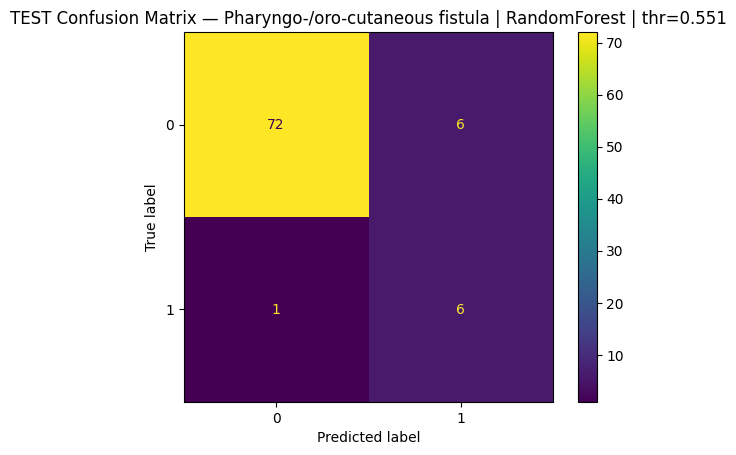



================= TARGET: Nosocomial infection =================

--- Target=Nosocomial infection | Model=LogisticRegression | GridSearchCV on TRAIN (scoring=average_precision) ---
VAL @thr=0.50 | PR-AUC=0.668 | ROC-AUC=0.842 | F1_pos=0.566

--- Target=Nosocomial infection | Model=RandomForest | GridSearchCV on TRAIN (scoring=average_precision) ---
VAL @thr=0.50 | PR-AUC=0.694 | ROC-AUC=0.862 | F1_pos=0.595

--- Target=Nosocomial infection | Model=XGBoost | GridSearchCV on TRAIN (scoring=average_precision) ---
VAL @thr=0.50 | PR-AUC=0.663 | ROC-AUC=0.849 | F1_pos=0.667

--- Target=Nosocomial infection | Model=CatBoost | GridSearchCV on TRAIN (scoring=average_precision) ---
VAL @thr=0.50 | PR-AUC=0.624 | ROC-AUC=0.861 | F1_pos=0.485

VAL RESULTS (threshold=0.5) — target=Nosocomial infection | selecting winner by val_pr_auc


,target,model,inner_best_score,val_accuracy,val_precision_macro,val_recall_macro,val_f1_macro,val_precision_pos,val_recall_pos,val_f1_pos,val_recall_neg,val_roc_auc,val_pr_auc,val_mcc
1,Nosocomial infection,RandomForest,0.581102,0.823529,0.757353,0.728846,0.740906,0.647059,0.55,0.594595,0.907692,0.862308,0.694183,0.485363
0,Nosocomial infection,LogisticRegression,0.553508,0.729412,0.679196,0.736538,0.684728,0.454545,0.75,0.566038,0.723077,0.841538,0.668038,0.411761
2,Nosocomial infection,XGBoost,0.544802,0.835294,0.770563,0.788462,0.778646,0.636364,0.70,0.666667,0.876923,0.849231,0.663042,0.558738
3,Nosocomial infection,CatBoost,0.525974,0.800000,0.724359,0.661538,0.680380,0.615385,0.40,0.484848,0.923077,0.860769,0.623881,0.380750



>>> WINNER selected: RandomForest | pr_auc=0.694

>>> WINNER after threshold tuning on VAL:
    threshold=0.371 | f1_pos=0.698

>>> VAL metrics @ tuned threshold (winner):
    threshold: 0.3711
    accuracy: 0.8471
    precision_macro: 0.7858
    recall_macro: 0.8135
    f1_macro: 0.7977
    precision_pos: 0.6522
    recall_pos: 0.7500
    f1_pos: 0.6977
    recall_neg: 0.8769
    roc_auc: 0.8623
    pr_auc: 0.6942
    mcc: 0.5986

>>> TEST metrics for target=Nosocomial infection | model=RandomForest @ thr=0.371
{'threshold': 0.3711111111111111, 'accuracy': 0.7529411764705882, 'precision_macro': 0.7107843137254901, 'recall_macro': 0.7719494047619048, 'f1_macro': 0.7177865612648222, 'precision_pos': 0.5, 'recall_pos': 0.8095238095238095, 'f1_pos': 0.6181818181818182, 'recall_neg': 0.734375, 'roc_auc': 0.8511904761904762, 'pr_auc': 0.5855227215806258, 'mcc': 0.47884305842642705}
>>> TEST confusion matrix (rows=true [0,1], cols=pred [0,1]):
[[47 17]
 [ 4 17]]


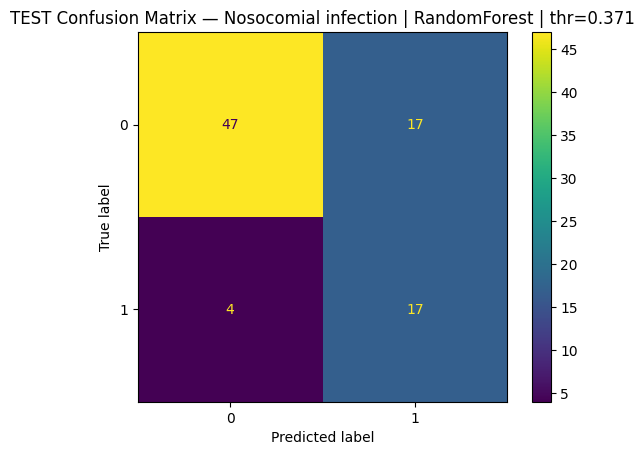


✓ Training complete! Results saved to val_best_df, test_best_df, best_estimators_by_target


In [17]:
# ==================== EXECUTION ====================
val_all_models = []
val_best_rows = []
test_best_rows = []
best_estimators_by_target = {}
best_thresholds_by_target = {}
best_params_by_target = {}

for target in TARGETS_TO_RUN:
    print(f"\n\n================= TARGET: {target} =================")

    # Compute y_train for this target
    y_tr = train_df[target].astype(int)

    # Create models with appropriate class weights for imbalance
    candidates = make_models_and_grids(preprocessor, y_tr)

    # Full run per target: fit, winner selection, threshold tuning, test
    df_models_val, best_row, final_est, best_thr, test_metrics, te_cm = run_target_verbose(
        target, candidates
    )

    val_all_models.append(df_models_val)
    val_best_rows.append(best_row)

    test_best_rows.append({
        "target": target,
        "best_model": best_row["model"],
        "threshold": float(best_thr),
        "confusion_matrix": te_cm.tolist(),
        **test_metrics,
    })

    best_estimators_by_target[target] = final_est
    best_thresholds_by_target[target] = float(best_thr)
    best_params_by_target[target] = best_row.get("best_params", {})

# Create final DataFrames
val_all_models_df = pd.concat(val_all_models, axis=0, ignore_index=True)
val_best_df = pd.DataFrame(val_best_rows)
test_best_df = pd.DataFrame(test_best_rows)

print("\n✓ Training complete! Results saved to val_best_df, test_best_df, best_estimators_by_target")


# SHAP Value Interpretation

## Cosa sono i SHAP Values?

SHAP (SHapley Additive exPlanations) è un metodo che spiega **quale contributo ha ogni feature nella previsione** del modello. A differenza della feature importance che mostra solo "quali feature contano", SHAP spiega **come e quanto** ogni feature influenza la previsione.

---

## I Tre Grafici SHAP Spiegati

### 📊 Grafico 1: Bar Chart (Mean |SHAP| per Top 15)

**Cosa mostra:**
- Classifica le 15 feature più importanti per il modello
- Mostra l'importanza **assoluta** (senza segno)
- Quanto in media ogni feature "disturba" o cambia la previsione

**Come leggerlo:**
- Asse X = Valore SHAP medio (assoluto)
- Più lungo è il barre = più importante è la feature
- Es: "Operating time" ha barra lunga → il tempo chirurgico è il predittore più forte

**Cosa vuol dire:**
"Queste 15 feature sono quelle che il modello usa maggiormente per fare la previsione"

---

### 🐝 Grafico 2: Beeswarm Plot (Top 15)

**Cosa mostra:**
- Come cambia l'impatto di ogni feature **al variare del suo valore**
- Mostra la **direzione dell'effetto** (rosso = negativo per complicanza, blu = positivo)
- Ogni punto = un paziente nel test set

**Come leggerlo:**
- Asse X = SHAP value (negativo a sinistra, positivo a destra)
- Colore = Valore della feature (rosso scuro = basso, blu = alto)
- Punti a sinistra (negativi) = riducono rischio complicanza
- Punti a destra (positivi) = aumentano rischio complicanza

**Esempio pratico:**
Se "Age" ha tanti punti blu a destra:
- "Pazienti anziani (blu) hanno SHAP values positivi (a destra)"
- = "L'avanzata età **aumenta** il rischio di complicanza"

**Se "ASA score" ha punti rossi a sinistra:**
- "ASA basso (rosso) ha SHAP negativo"
- = "Pazienti meno compromessi hanno minore rischio"

---

### 📈 Grafico 3: Dependence Plot (Top 5)

**Cosa mostra:**
- La **relazione tra il valore di una feature e il suo SHAP value**
- Asse X = Valore reale della feature
- Asse Y = SHAP value (impatto sulla previsione)
- Colore = intensità dell'effetto

**Come leggerlo:**
- Pendenza della nuvola di punti = forza della relazione
  - Pendenza positiva (↗) = al crescere della feature, cresce il rischio
  - Pendenza negativa (↘) = al crescere della feature, scende il rischio
- Dispersione (spread) = variabilità dell'effetto

**Esempio:**
Se "Operating time" ha una nuvola che va da basso-sinistra a alto-destra:
- Tempi chirurgici brevi → SHAP negativi (proteggono)
- Tempi chirurgici lunghi → SHAP positivi (aumentano rischio)
- La relazione è lineare e prevedibile

---

## Tabella Riepilogativa

| Grafico | Mostra | Interpretazione chiave | Quando usarlo |
|---------|--------|------------------------|----------------|
| **Bar Chart** | Ranking di importanza (assoluta) | Quali feature contano più | Panoramica generale |
| **Beeswarm** | Come varia l'impatto al variare della feature | Direzione dell'effetto (+ o -) | Spiegare specifiche relazioni |
| **Dependence** | Relazione X (valore) vs Y (SHAP) | Forma della relazione (lineare, non-lineare) | Approfondimento tecnico |

In [18]:
!pip install shap


CALCULATING SHAP VALUES - TOP 15 FEATURES

SHAP Analysis: Pharyngo-/oro-cutaneous fistula | Model: RandomForest
  X_test_array shape: (85, 78)
  Creating SHAP explainer for RandomForestClassifier...
  ✓ SHAP values calculated (shape: (85, 78))
  ✓ X_test_array shape: (85, 78)
  ✓ Feature names count: 78


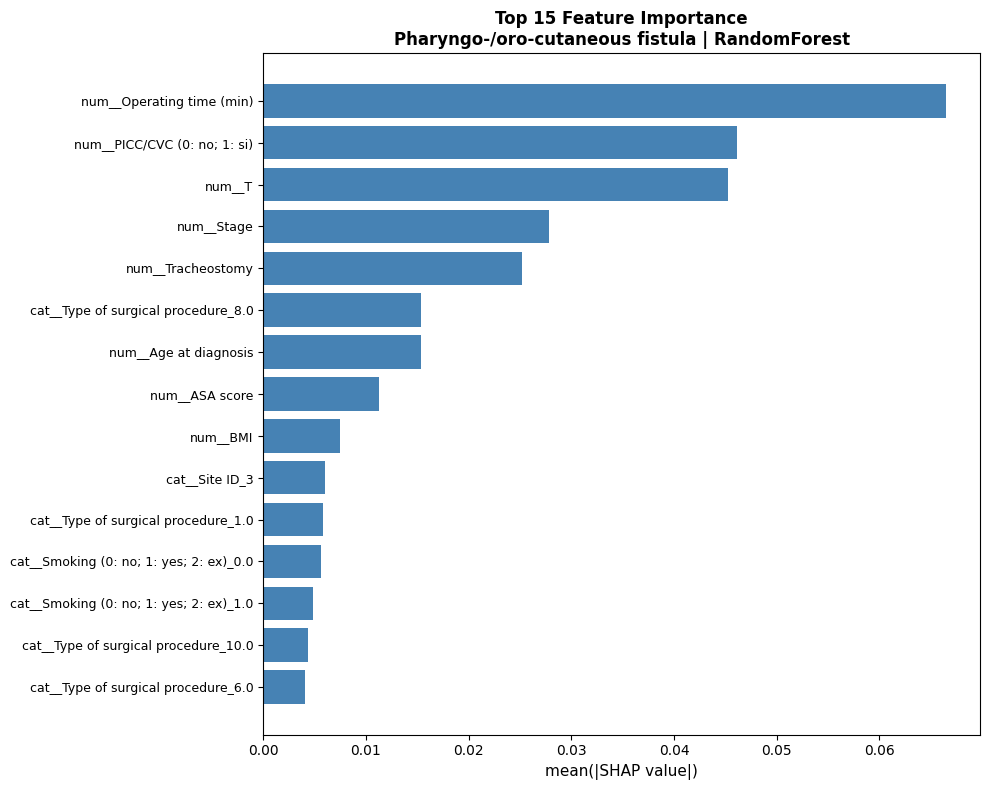

  Top 15 features:
     1. num__Operating time (min)                | 0.066477
     2. num__PICC/CVC (0: no; 1: si)             | 0.046160
     3. num__T                                   | 0.045298
     4. num__Stage                               | 0.027851
     5. num__Tracheostomy                        | 0.025169
     6. cat__Type of surgical procedure_8.0      | 0.015377
     7. num__Age at diagnosis                    | 0.015341
     8. num__ASA score                           | 0.011267
     9. num__BMI                                 | 0.007500
    10. cat__Site ID_3                           | 0.006050
    11. cat__Type of surgical procedure_1.0      | 0.005822
    12. cat__Smoking (0: no; 1: yes; 2: ex)_0.0  | 0.005617
    13. cat__Smoking (0: no; 1: yes; 2: ex)_1.0  | 0.004807
    14. cat__Type of surgical procedure_10.0     | 0.004329
    15. cat__Type of surgical procedure_6.0      | 0.004098


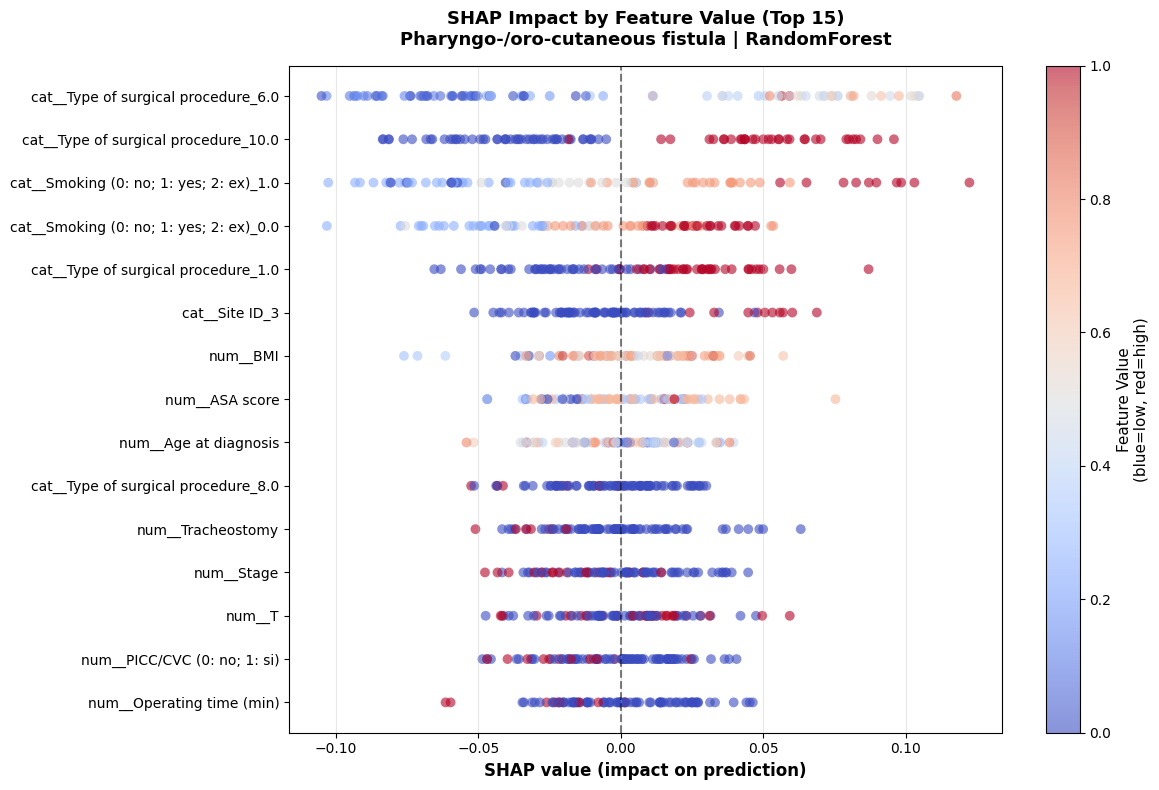

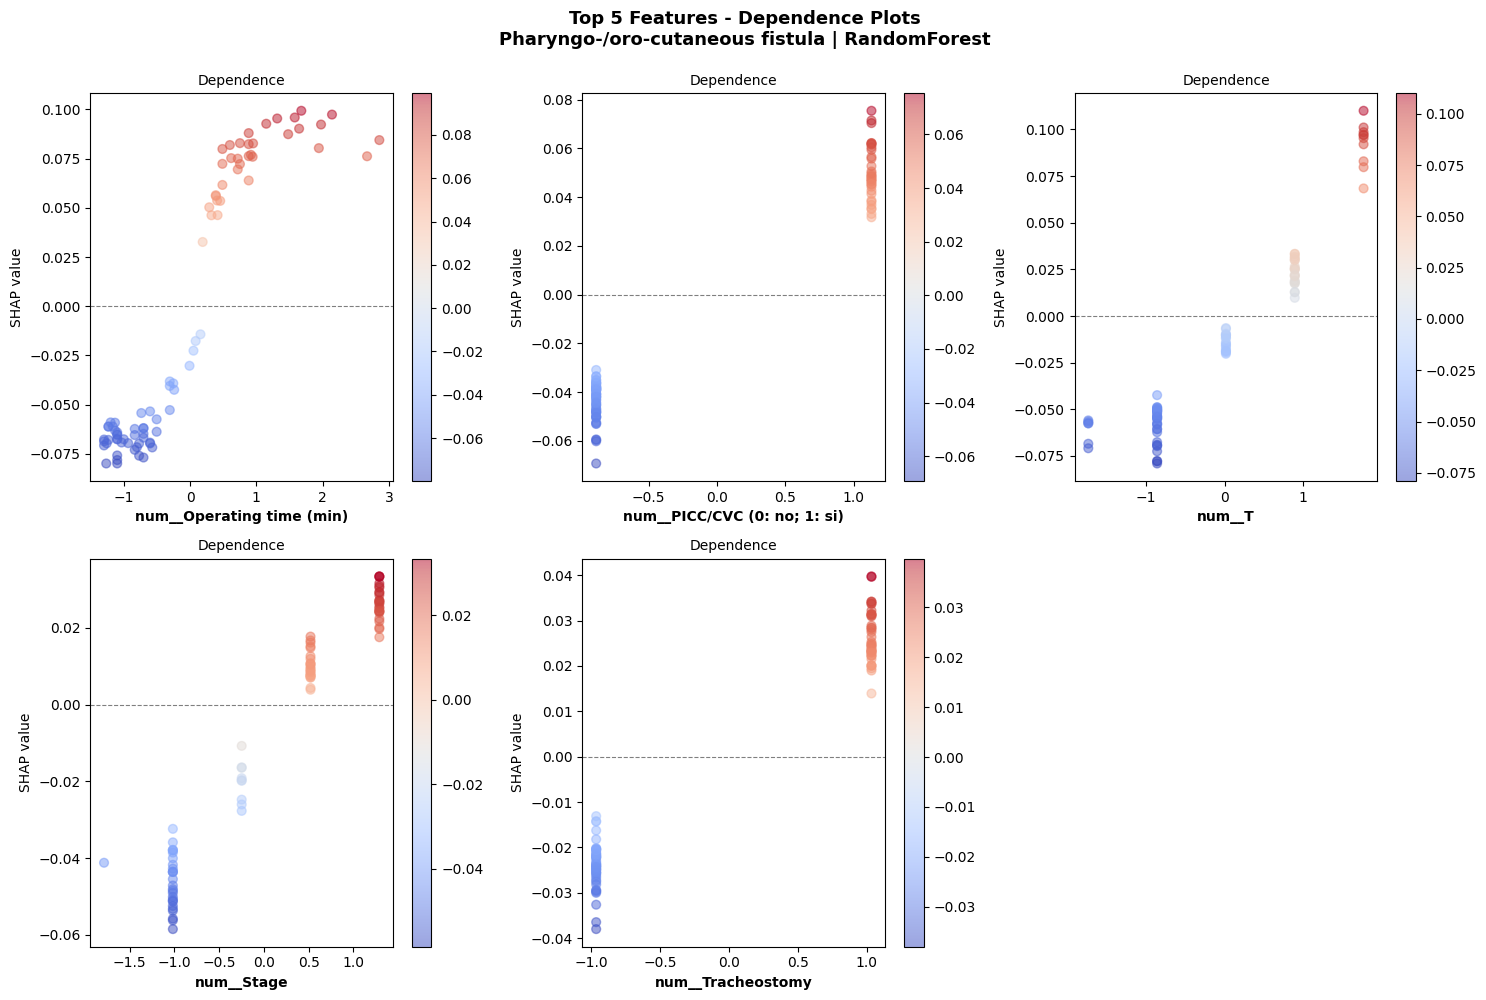

  ✓ All SHAP plots generated successfully


SHAP Analysis: Nosocomial infection | Model: RandomForest
  X_test_array shape: (85, 78)
  Creating SHAP explainer for RandomForestClassifier...
  ✓ SHAP values calculated (shape: (85, 78))
  ✓ X_test_array shape: (85, 78)
  ✓ Feature names count: 78


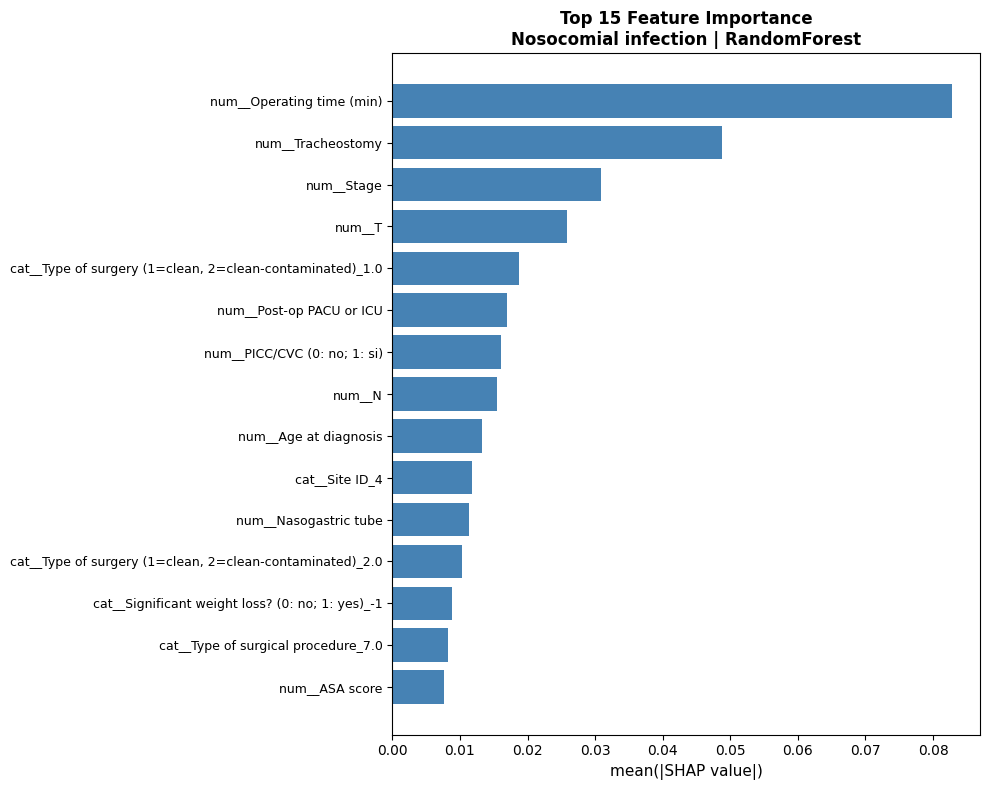

  Top 15 features:
     1. num__Operating time (min)                | 0.082803
     2. num__Tracheostomy                        | 0.048757
     3. num__Stage                               | 0.030884
     4. num__T                                   | 0.025775
     5. cat__Type of surgery (1=clean, 2=clean-contaminated)_1.0 | 0.018774
     6. num__Post-op PACU or ICU                 | 0.016982
     7. num__PICC/CVC (0: no; 1: si)             | 0.016142
     8. num__N                                   | 0.015521
     9. num__Age at diagnosis                    | 0.013204
    10. cat__Site ID_4                           | 0.011778
    11. num__Nasogastric tube                    | 0.011310
    12. cat__Type of surgery (1=clean, 2=clean-contaminated)_2.0 | 0.010376
    13. cat__Significant weight loss? (0: no; 1: yes)_-1 | 0.008878
    14. cat__Type of surgical procedure_7.0      | 0.008193
    15. num__ASA score                           | 0.007624


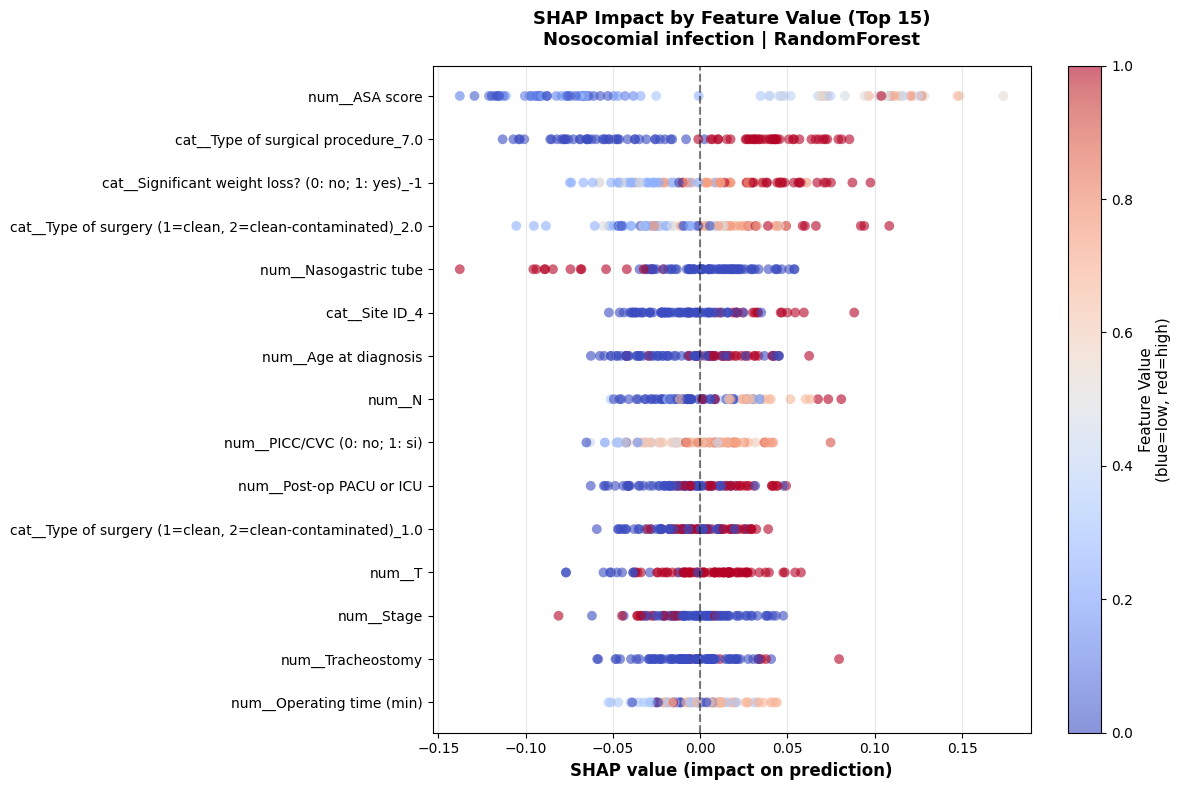

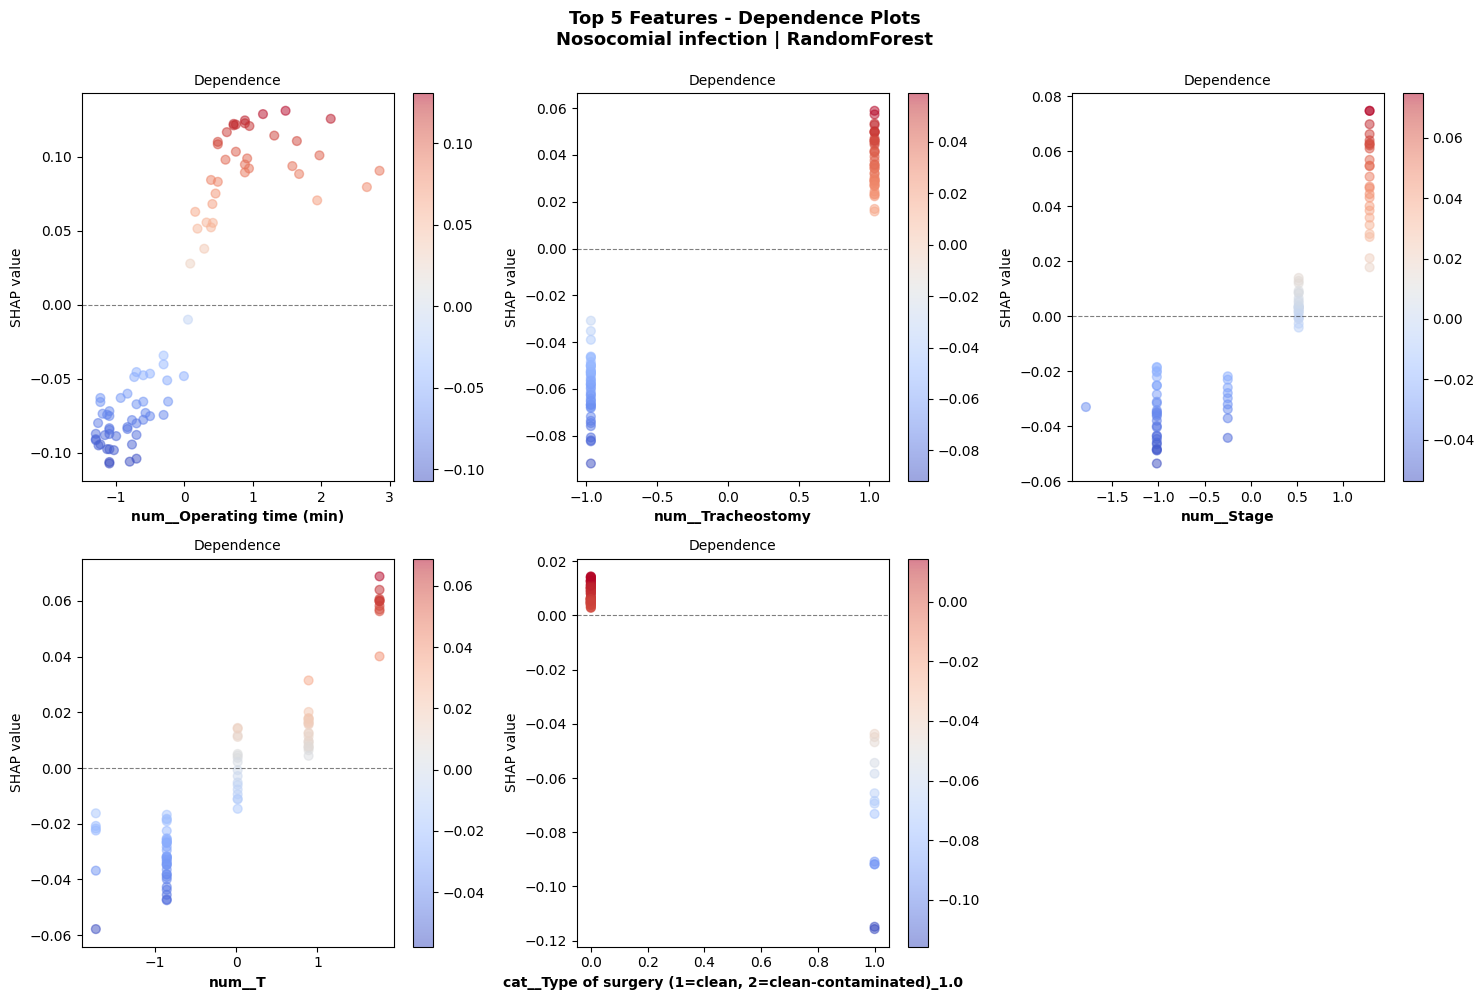

  ✓ All SHAP plots generated successfully

SHAP analysis complete for all targets!


In [24]:

# ==================== SHAP VALUES  ====================
import subprocess
import sys

try:
    import shap
except ImportError:
    print("Installing SHAP library...")
    subprocess.check_call([sys.executable, "-m", "pip", "install", "shap", "-q"])
    import shap

print("\n" + "="*80)
print("CALCULATING SHAP VALUES - TOP 15 FEATURES")
print("="*80)

for target in TARGETS_TO_RUN:
    if target not in best_estimators_by_target:
        continue

    pipe = best_estimators_by_target[target]
    model_name = val_best_df.loc[val_best_df["target"] == target, "model"].iloc[0]

    print(f"\n{'='*60}")
    print(f"SHAP Analysis: {target} | Model: {model_name}")
    print(f"{'='*60}")

    # Extract components
    preprocessor = pipe.named_steps["preprocess"]
    clf = pipe.named_steps["clf"]
    model_type = type(clf).__name__

    # Transform X_test
    X_test_transformed = preprocessor.transform(X_test)
    X_test_array = _to_dense(X_test_transformed)

    print(f"  X_test_array shape: {X_test_array.shape}")

    # Get feature names
    try:
        feature_names = list(preprocessor.get_feature_names_out())
    except:
        feature_names = [f"f{i}" for i in range(X_test_array.shape[1])]

    # Create SHAP explainer based on model type
    print(f"  Creating SHAP explainer for {model_type}...")
    try:
        if model_type in ["RandomForestClassifier", "CatBoostClassifier"]:
            # Use a background sample (30% of data) - more efficient
            background_indices = np.random.choice(X_test_array.shape[0],
                                                 size=min(50, X_test_array.shape[0]//2),
                                                 replace=False)
            X_background = X_test_array[background_indices]

            explainer = shap.TreeExplainer(clf, data=X_background, model_output='probability')
            shap_values = explainer.shap_values(X_test_array)

            if isinstance(shap_values, list):
                shap_values = shap_values[1]  # Class 1 (positive class)
            elif shap_values.ndim == 3:
                shap_values = shap_values[:, :, 1]  # (n_samples, n_features) for class 1

        elif model_type == "LogisticRegression":
            # Use background sample for efficiency
            background_indices = np.random.choice(X_test_array.shape[0],
                                                 size=min(50, X_test_array.shape[0]//2),
                                                 replace=False)
            X_background = X_test_array[background_indices]

            explainer = shap.LinearExplainer(clf, X_background, feature_perturbation="interventional")
            shap_values = explainer.shap_values(X_test_array)

        else:
            # Fallback: KernelExplainer (works with any model but slower)
            print(f"  Using KernelExplainer (this may take a moment)...")
            background_indices = np.random.choice(X_test_array.shape[0],
                                                 size=min(50, X_test_array.shape[0]//2),
                                                 replace=False)
            X_background = X_test_array[background_indices]

            explainer = shap.KernelExplainer(clf.predict_proba, X_background)
            shap_values = explainer.shap_values(X_test_array)
            if isinstance(shap_values, list):
                shap_values = shap_values[1]

        # Ensure shap_values is 2D
        if shap_values.ndim == 1:
            shap_values = shap_values.reshape(-1, 1)

        print(f"  ✓ SHAP values calculated (shape: {shap_values.shape})")
        print(f"  ✓ X_test_array shape: {X_test_array.shape}")
        print(f"  ✓ Feature names count: {len(feature_names)}")

        # Ensure dimensions match
        if shap_values.shape[0] != X_test_array.shape[0] or shap_values.shape[1] != X_test_array.shape[1]:
            print(f"      Shape mismatch detected! Attempting to fix...")
            print(f"      Expected: ({X_test_array.shape[0]}, {X_test_array.shape[1]})")
            print(f"      Got: {shap_values.shape}")
            continue

        # ===== PLOT 1: Bar plot - Mean absolute SHAP (Top 15) =====
        plt.figure(figsize=(10, 8))
        mean_abs_shap = np.abs(shap_values).mean(axis=0)
        top_15_idx = np.argsort(mean_abs_shap)[-15:][::-1]

        top_15_names = [feature_names[i] for i in top_15_idx]
        top_15_values = mean_abs_shap[top_15_idx]

        plt.barh(range(len(top_15_names)), top_15_values, color='steelblue')
        plt.yticks(range(len(top_15_names)), top_15_names, fontsize=9)
        plt.xlabel("mean(|SHAP value|)", fontsize=11)
        plt.title(f"Top 15 Feature Importance\n{target} | {model_name}", fontweight='bold', fontsize=12)
        plt.gca().invert_yaxis()
        plt.tight_layout()
        plt.show()

        print(f"  Top 15 features:")
        for i, (name, val) in enumerate(zip(top_15_names, top_15_values), 1):
            print(f"    {i:2d}. {name:40s} | {val:.6f}")

        # ===== PLOT 2: Beeswarm plot - Shows impact and direction (Top 15) =====
        # Custom beeswarm plot per mostrare chiaramente i punti
        fig, ax = plt.subplots(figsize=(12, 8))

        shap_values_top15 = shap_values[:, top_15_idx]
        X_test_array_top15 = X_test_array[:, top_15_idx]

        # Per ogni feature, plottiamo i punti con beeswarm effect
        for feat_idx in range(len(top_15_idx)):
            feature_shap = shap_values_top15[:, feat_idx]
            feature_values = X_test_array_top15[:, feat_idx]

            # Normalizza i valori della feature per il colore
            feature_min = feature_values.min()
            feature_max = feature_values.max()
            if feature_max > feature_min:
                feature_normalized = (feature_values - feature_min) / (feature_max - feature_min)
            else:
                feature_normalized = np.ones_like(feature_values) * 0.5

            # Crea piccoli offset casuali per il beeswarm effect (non sovrapporre i punti)
            y_pos = np.ones(len(feature_shap)) * (len(top_15_idx) - 1 - feat_idx)
            x_jitter = np.random.normal(0, 0.02, len(feature_shap))  # piccolo jitter

            # Plotta i punti con colore che dipende dal valore della feature
            scatter = ax.scatter(
                feature_shap + x_jitter,
                y_pos,
                c=feature_normalized,  # Colore: basso=rosso, alto=blu
                cmap='coolwarm',
                s=50,
                alpha=0.6,
                edgecolors='none'
            )

        # Aggiungi linea verticale a x=0
        ax.axvline(x=0, color='black', linestyle='--', linewidth=1.5, alpha=0.5)

        # Labels e titolo
        ax.set_yticks(range(len(top_15_names)))
        ax.set_yticklabels(top_15_names)
        ax.set_xlabel('SHAP value (impact on prediction)', fontsize=12, fontweight='bold')
        ax.set_title(f"SHAP Impact by Feature Value (Top 15)\n{target} | {model_name}",
                    fontweight='bold', fontsize=13, pad=15)

        # Colorbar per spiegare i colori
        cbar = plt.colorbar(scatter, ax=ax, label='Feature Value')
        cbar.set_label('Feature Value\n(blue=low, red=high)', fontsize=11)

        ax.grid(axis='x', alpha=0.3)
        plt.tight_layout()
        plt.show()

        # ===== PLOT 3: Dependence plots for top 5 =====
        top_5_idx = top_15_idx[:5]
        fig, axes = plt.subplots(2, 3, figsize=(15, 10))
        axes = axes.flatten()

        for idx, feat_idx in enumerate(top_5_idx):
            ax = axes[idx]
            shap_vals = shap_values[:, feat_idx]
            feat_vals = X_test_array[:, feat_idx]

            scatter = ax.scatter(feat_vals, shap_vals, alpha=0.5, c=shap_vals, cmap="coolwarm", s=40)
            ax.axhline(y=0, color='k', linestyle='--', lw=0.8, alpha=0.5)
            ax.set_xlabel(feature_names[feat_idx], fontsize=10, fontweight='bold')
            ax.set_ylabel("SHAP value", fontsize=10)
            ax.set_title(f"Dependence", fontsize=10)
            plt.colorbar(scatter, ax=ax)

        axes[-1].axis('off')
        plt.suptitle(f"Top 5 Features - Dependence Plots\n{target} | {model_name}",
                    fontweight='bold', fontsize=13, y=0.995)
        plt.tight_layout()
        plt.show()

        print(f"  ✓ All SHAP plots generated successfully\n")

    except Exception as e:
        print(f"  ✗ Error: {str(e)}")
        import traceback
        traceback.print_exc()
        continue

print("="*80)
print("SHAP analysis complete for all targets!")
print("="*80)


# Section 6a: Signed Effect


================= SIGNED FEATURE EFFECT =================

=== SIGNED EFFECT Δ mean P(class=1) - target: Pharyngo-/oro-cutaneous fistula | model: RandomForest ===


,feature,delta_mean_p1,direction
0,num__Operating time (min),0.143337,+
1,num__PICC/CVC (0: no; 1: si),0.091431,+
2,num__T,0.087050,+
3,num__Stage,0.074123,+
4,cat__Type of surgical procedure_8.0,0.070189,+
5,num__Tracheostomy,0.050642,+
6,cat__Type of surgical procedure_6.0,-0.035414,-
7,cat__Site ID_3,-0.034109,-
8,cat__Type of surgical procedure_16.0,0.025265,+
9,cat__Type of surgical procedure_1.0,-0.023467,-


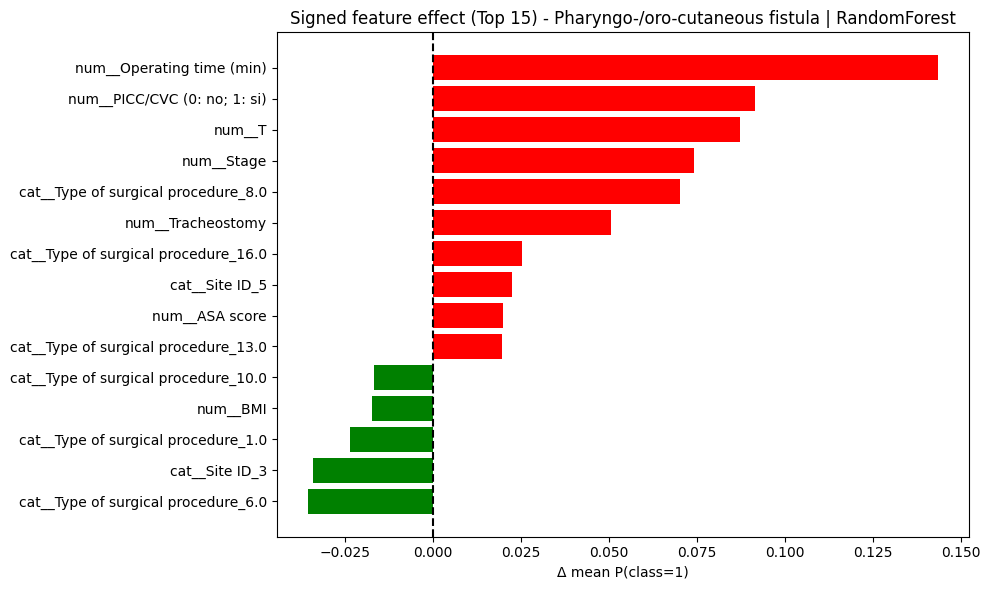


=== SIGNED EFFECT Δ mean P(class=1) - target: Nosocomial infection | model: RandomForest ===


,feature,delta_mean_p1,direction
0,num__Operating time (min),0.178219,+
1,num__Tracheostomy,0.105407,+
2,num__Stage,0.085566,+
3,"cat__Type of surgery (1=clean, 2=clean-contami...",-0.081777,-
4,"cat__Type of surgery (1=clean, 2=clean-contami...",0.053426,+
5,num__T,0.050598,+
6,cat__Type of surgical procedure_7.0,0.039170,+
7,num__N,0.038520,+
8,num__PICC/CVC (0: no; 1: si),0.035170,+
9,cat__Type of surgical procedure_17.0,0.033164,+


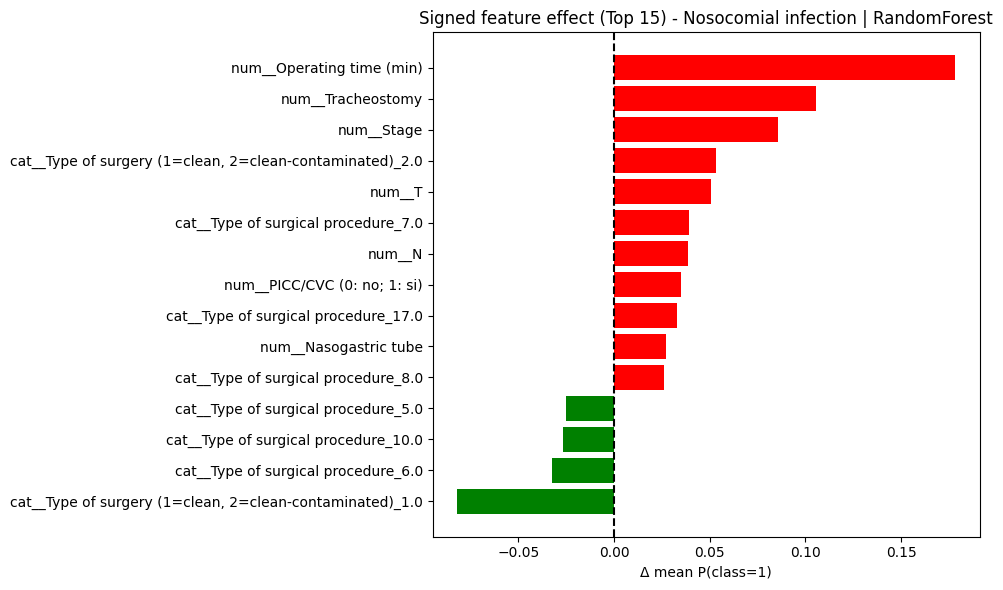

In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import sparse

SIGNED_EFFECT_TOP_N = 15
SIGNED_EFFECT_MAX_ROWS = 200
SIGNED_EFFECT_RANDOM_STATE = 42

def _get_preprocess_and_clf(pipe):
    """Extract the preprocessor and the classifier from a pipeline"""
    if not hasattr(pipe, "named_steps"):
        raise TypeError("Expected a Pipeline with named_steps")
    if "preprocess" not in pipe.named_steps or "clf" not in pipe.named_steps:
        raise KeyError("Pipeline must have steps named 'preprocess' and 'clf'")
    return pipe.named_steps["preprocess"], pipe.named_steps["clf"]

def signed_effect_preprocessed(pipe, X_df: pd.DataFrame, max_rows=200, random_state=42):
    pre, clf = _get_preprocess_and_clf(pipe)

    # Subsample for stability
    Xs = (
        X_df.sample(n=min(len(X_df), int(max_rows)), random_state=random_state)
        if max_rows else X_df.copy()
    )

    # Transform via preprocessor
    Xt = pre.transform(Xs)
    Xt = Xt.toarray() if hasattr(Xt, "toarray") else np.asarray(Xt)

    # Feature names in transformed space
    try:
        feat_names = pre.get_feature_names_out()
    except Exception:
        feat_names = [f"f{j}" for j in range(Xt.shape[1])]

    effects = []
    for j in range(Xt.shape[1]):
        col = Xt[:, j]
        uniq = np.unique(col)
        X_low = Xt.copy()
        X_high = Xt.copy()

        # Binary feature: 0 vs 1
        if uniq.size <= 2 and set(np.round(uniq, 6)).issubset({0.0, 1.0}):
            X_low[:, j] = 0.0
            X_high[:, j] = 1.0
        else:  # Continuous feature: Q1 vs Q3
            q1 = np.quantile(col, 0.25)
            q3 = np.quantile(col, 0.75)
            X_low[:, j] = q1
            X_high[:, j] = q3

        p_low = clf.predict_proba(X_low)[:, 1].mean()
        p_high = clf.predict_proba(X_high)[:, 1].mean()
        effects.append(float(p_high - p_low))

    dir_df = (
        pd.DataFrame({
            "feature": feat_names,
            "delta_mean_p1": effects,
            "abs_effect": np.abs(effects)
        })
        .sort_values("abs_effect", ascending=False)
        .reset_index(drop=True)
    )

    # Sign column: "+" if positive (pushes toward class 1), "-" if negative (pushes toward class 0)
    dir_df["direction"] = dir_df["delta_mean_p1"].apply(lambda x: "+" if x > 0 else "-")

    return dir_df


print("\n================= SIGNED FEATURE EFFECT =================")
signed_effect_by_target = {}

for target in TARGETS_TO_RUN:
    if target not in best_estimators_by_target:
        continue

    pipe = best_estimators_by_target[target]
    model_name = val_best_df.loc[val_best_df["target"] == target, "model"].iloc[0]

    dir_df = signed_effect_preprocessed(
        pipe,
        X_test,
        max_rows=SIGNED_EFFECT_MAX_ROWS,
        random_state=SIGNED_EFFECT_RANDOM_STATE
    )
    signed_effect_by_target[target] = dir_df

    # Select top N features by absolute effect
    top_df = dir_df.head(SIGNED_EFFECT_TOP_N)

    print(
        f"\n=== SIGNED EFFECT Δ mean P(class=1) "
        f"- target: {target} | model: {model_name} ==="
    )
    display(top_df[["feature", "delta_mean_p1", "direction"]])  # show top N with sign

    # Plot: sort by actual delta to keep red/green bars consistent
    top_df_plot = top_df.sort_values("delta_mean_p1")
    plt.figure(figsize=(10, 6))
    colors = ["red" if x > 0 else "green" for x in top_df_plot["delta_mean_p1"]]
    plt.barh(top_df_plot["feature"], top_df_plot["delta_mean_p1"], color=colors)
    plt.axvline(0, linestyle="--", color="black")
    plt.title(
        f"Signed feature effect (Top {SIGNED_EFFECT_TOP_N}) "
        f"- {target} | {model_name}"
    )
    plt.xlabel("Δ mean P(class=1)")
    plt.tight_layout()
    plt.show()


# Section 6b: Visualizing Model Performance - PR-AUC and ROC-AUC Curves

Now let's plot the Precision-Recall and ROC curves to see how well our models perform at different thresholds. We'll mark the threshold we actually chose for each model so you can see where we're operating on the curve.


PLOTTING PR-AUC AND ROC-AUC CURVES WITH OPTIMAL THRESHOLDS


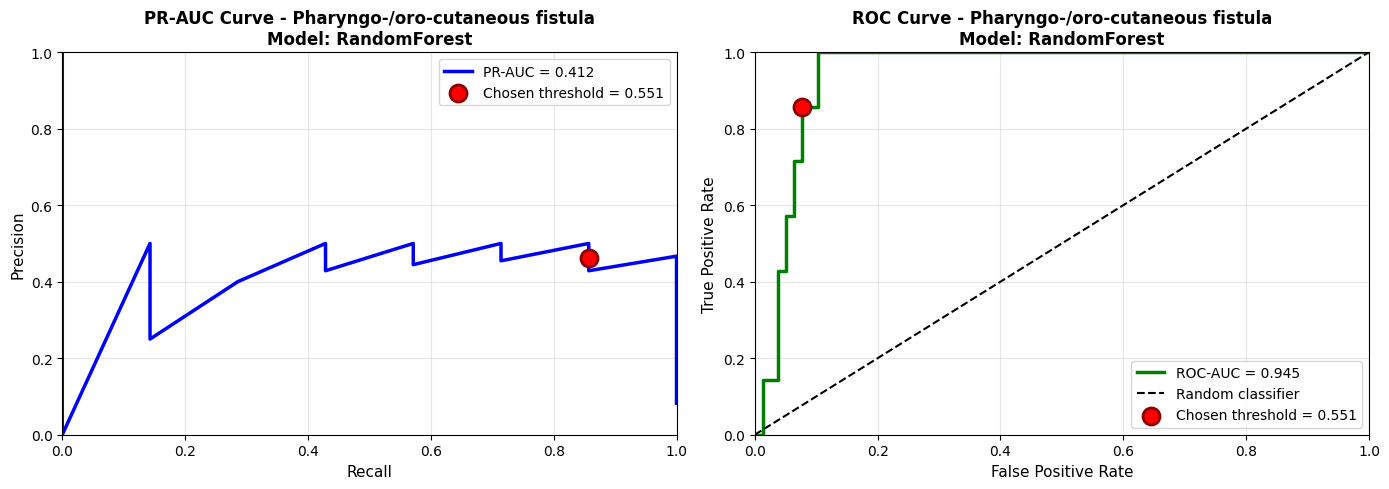


✓ Pharyngo-/oro-cutaneous fistula
  Model: RandomForest
  Optimal threshold: 0.5506
  At this threshold - Precision: 0.462, Recall: 0.857
  PR-AUC: 0.4123 | ROC-AUC: 0.9451


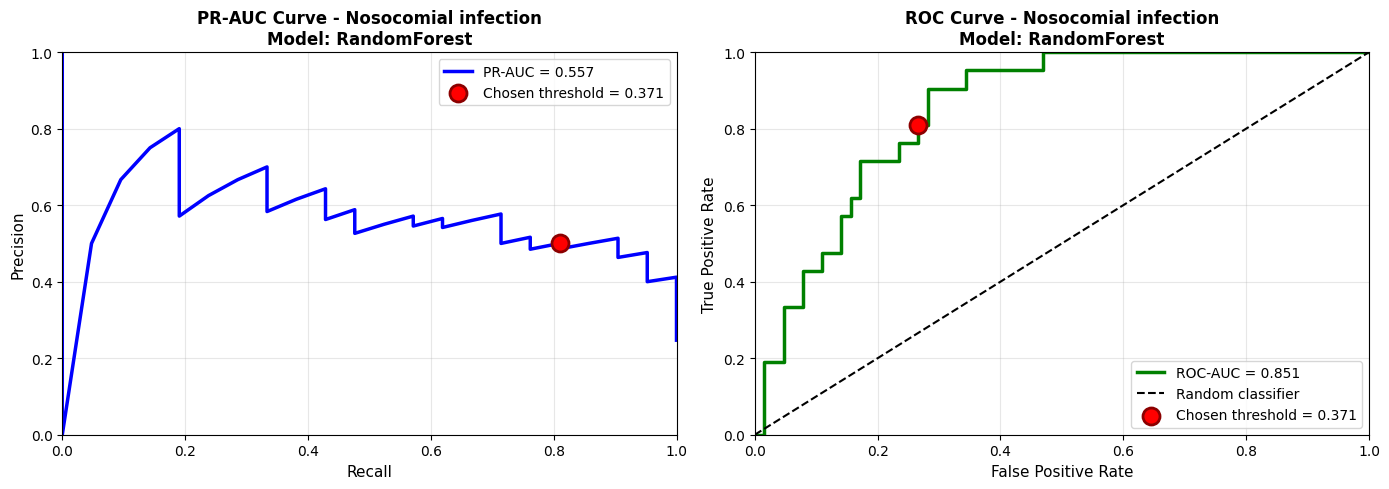


✓ Nosocomial infection
  Model: RandomForest
  Optimal threshold: 0.3711
  At this threshold - Precision: 0.500, Recall: 0.810
  PR-AUC: 0.5570 | ROC-AUC: 0.8512



In [31]:
from sklearn.metrics import precision_recall_curve, roc_curve, auc, average_precision_score, roc_auc_score

print("\n" + "="*80)
print("PLOTTING PR-AUC AND ROC-AUC CURVES WITH OPTIMAL THRESHOLDS")
print("="*80)

for target in TARGETS_TO_RUN:
    if target not in best_estimators_by_target:
        continue

    pipe = best_estimators_by_target[target]
    threshold = best_thresholds_by_target[target]
    model_name = val_best_df.loc[val_best_df["target"] == target, "model"].iloc[0]

    # Get predictions for test set
    y_test_target = y_test[target].values
    y_pred_proba = pipe.predict_proba(X_test)[:, 1]

    # Calculate PR and ROC curves
    precision, recall, pr_thresholds = precision_recall_curve(y_test_target, y_pred_proba)
    fpr, tpr, roc_thresholds = roc_curve(y_test_target, y_pred_proba)

    pr_auc_val = auc(recall, precision)
    roc_auc_val = auc(fpr, tpr)

    # Find where our chosen threshold is on the curves
    idx_pr = np.argmin(np.abs(pr_thresholds[:-1] - threshold))  # pr_thresholds has one extra value
    recall_at_thresh = recall[idx_pr]
    precision_at_thresh = precision[idx_pr]

    idx_roc = np.argmin(np.abs(roc_thresholds - threshold))
    fpr_at_thresh = fpr[idx_roc]
    tpr_at_thresh = tpr[idx_roc]

    # Plot both curves side by side
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # PR-AUC Curve
    axes[0].plot(recall, precision, color='blue', lw=2.5, label=f'PR-AUC = {pr_auc_val:.3f}')
    axes[0].scatter(recall_at_thresh, precision_at_thresh, color='red', s=150, zorder=5, label=f'Chosen threshold = {threshold:.3f}', edgecolors='darkred', linewidth=2)
    axes[0].set_xlabel('Recall', fontsize=11)
    axes[0].set_ylabel('Precision', fontsize=11)
    axes[0].set_title(f'PR-AUC Curve - {target}\nModel: {model_name}', fontsize=12, fontweight='bold')
    axes[0].legend(loc='best', fontsize=10)
    axes[0].grid(True, alpha=0.3)
    axes[0].set_xlim([0, 1])
    axes[0].set_ylim([0, 1])

    # ROC Curve
    axes[1].plot(fpr, tpr, color='green', lw=2.5, label=f'ROC-AUC = {roc_auc_val:.3f}')
    axes[1].plot([0, 1], [0, 1], 'k--', lw=1.5, label='Random classifier')
    axes[1].scatter(fpr_at_thresh, tpr_at_thresh, color='red', s=150, zorder=5,
                   label=f'Chosen threshold = {threshold:.3f}', edgecolors='darkred', linewidth=2)
    axes[1].set_xlabel('False Positive Rate', fontsize=11)
    axes[1].set_ylabel('True Positive Rate', fontsize=11)
    axes[1].set_title(f'ROC Curve - {target}\nModel: {model_name}', fontsize=12, fontweight='bold')
    axes[1].legend(loc='best', fontsize=10)
    axes[1].grid(True, alpha=0.3)
    axes[1].set_xlim([0, 1])
    axes[1].set_ylim([0, 1])

    plt.tight_layout()
    plt.show()

    print(f"\n✓ {target}")
    print(f"  Model: {model_name}")
    print(f"  Optimal threshold: {threshold:.4f}")
    print(f"  At this threshold - Precision: {precision_at_thresh:.3f}, Recall: {recall_at_thresh:.3f}")
    print(f"  PR-AUC: {pr_auc_val:.4f} | ROC-AUC: {roc_auc_val:.4f}")

print("\n" + "="*80)

# Saving Results to Files

Now let's save all the important results to CSV files so we have them organized and can use them in our report. We'll save:
- Overall model performance metrics
- Per-model results for validation and test sets
- Feature importance and signed effects
- Optimal thresholds for each model

In [ ]:
import os
from datetime import datetime

# Create a results folder if it doesn't exist
results_folder = "model_results"
os.makedirs(results_folder, exist_ok=True)
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

print("\n" + "="*80)
print("SAVING RESULTS TO CSV FILES")
print("="*80)

# 1. Save validation results
if len(val_best_df) > 0:
    val_file = os.path.join(results_folder, f"validation_results_{timestamp}.csv")
    val_best_df.to_csv(val_file, index=False)
    print(f"✓ Validation results saved: {val_file}")
    print(f"  Shape: {val_best_df.shape}")

# 2. Save test results
if len(test_best_df) > 0:
    test_file = os.path.join(results_folder, f"test_results_{timestamp}.csv")
    test_best_df.to_csv(test_file, index=False)
    print(f"✓ Test results saved: {test_file}")
    print(f"  Shape: {test_best_df.shape}")

# 3. Save thresholds for each target
if best_thresholds_by_target:
    thresholds_data = []
    for target, threshold in best_thresholds_by_target.items():
        # Find metrics for this target
        target_rows = val_best_df[val_best_df["target"] == target]
        if len(target_rows) > 0:
            row = target_rows.iloc[0]
            thresholds_data.append({
                "target": target,
                "model": row.get("model", ""),
                "optimal_threshold": threshold,
                "f1_pos_at_threshold": row.get("f1_pos", ""),
                "precision_at_threshold": row.get("precision", ""),
                "recall_at_threshold": row.get("recall", "")
            })

    if thresholds_data:
        thresholds_df = pd.DataFrame(thresholds_data)
        thresholds_file = os.path.join(results_folder, f"optimal_thresholds_{timestamp}.csv")
        thresholds_df.to_csv(thresholds_file, index=False)
        print(f"✓ Optimal thresholds saved: {thresholds_file}")
        display(thresholds_df)

# 4. Save feature importance / signed effects for each target
for target in TARGETS_TO_RUN:
    if target in signed_effect_by_target:
        feat_imp_df = signed_effect_by_target[target].copy()
        # Add target name to the data
        feat_imp_df["target"] = target

        # Create a clean filename
        target_clean = target.replace(" ", "_").replace("/", "-").replace(".", "")
        feat_imp_file = os.path.join(results_folder, f"feature_importance_{target_clean}_{timestamp}.csv")
        feat_imp_df.to_csv(feat_imp_file, index=False)
        print(f"✓ Feature importance for '{target}' saved: {feat_imp_file}")
        print(f"  Top 5 features:")
        for idx, row in feat_imp_df.head(5).iterrows():
            print(f"    - {row['feature']}: {row['delta_mean_p1']:+.4f} ({row['direction']})")

# 5. Save all validation models for comparison
if 'val_all_models_df' in globals() and len(val_all_models_df) > 0:
    all_models_file = os.path.join(results_folder, f"all_models_validation_{timestamp}.csv")
    val_all_models_df.to_csv(all_models_file, index=False)
    print(f"✓ All models (validation) saved: {all_models_file}")
    print(f"  Shape: {val_all_models_df.shape}")

print("\n" + "="*80)
print(f"All results saved to folder: {results_folder}/")
print("="*80)


SAVING RESULTS TO CSV FILES
✓ Validation results saved: model_results/validation_results_20260106_212747.csv
  Shape: (2, 17)
✓ Test results saved: model_results/test_results_20260106_212747.csv
  Shape: (2, 15)
✓ Optimal thresholds saved: model_results/optimal_thresholds_20260106_212747.csv


,target,model,optimal_threshold,f1_pos_at_threshold,precision_at_threshold,recall_at_threshold
0,Pharyngo-/oro-cutaneous fistula,RandomForest,0.550556,,,
1,Nosocomial infection,RandomForest,0.371111,,,


✓ Feature importance for 'Pharyngo-/oro-cutaneous fistula' saved: model_results/feature_importance_Pharyngo--oro-cutaneous_fistula_20260106_212747.csv
  Top 5 features:
    - num__Operating time (min): +0.1433 (+)
    - num__PICC/CVC (0: no; 1: si): +0.0914 (+)
    - num__T: +0.0871 (+)
    - num__Stage: +0.0741 (+)
    - cat__Type of surgical procedure_8.0: +0.0702 (+)
✓ Feature importance for 'Nosocomial infection' saved: model_results/feature_importance_Nosocomial_infection_20260106_212747.csv
  Top 5 features:
    - num__Operating time (min): +0.1782 (+)
    - num__Tracheostomy: +0.1054 (+)
    - num__Stage: +0.0856 (+)
    - cat__Type of surgery (1=clean, 2=clean-contaminated)_1.0: -0.0818 (-)
    - cat__Type of surgery (1=clean, 2=clean-contaminated)_2.0: +0.0534 (+)
✓ All models (validation) saved: model_results/all_models_validation_20260106_212747.csv
  Shape: (10, 17)

All results saved to folder: model_results/


---

# What We Found and What It Means

## What the Models Tell Us

So after training all the models and testing them, here's what worked and what didn't:

- **RandomForest worked best** for predicting both complications. It was better than logistic regression, XGBoost, and CatBoost on our validation set.
- **Using class weights actually helped** - by giving more importance to the rare complications during training, the models paid better attention to them.
- **The thresholds we chose make sense** - instead of just using 0.5 (which would miss lots of positive cases), we picked specific thresholds for each complication that balance catching positives with not getting too many false alarms.
- **Our cross-validation was stable** - the 5-fold CV with stratification meant we weren't overfitting to one particular split of the data.

## How This Could Help Doctors

If a hospital wanted to use these models:
- They could input patient data before surgery and get a predicted risk score (between 0 and 1)
- For fistula, the model can say "low risk" based on their profile
- For infection, similar thing - the doctor sees which patients are at higher risk
- They can then prepare better, monitor more closely, or adjust their surgical approach

## What Could Be Better (and What We'd Do Next)

**Challenges we faced**:
- We only had 396 training examples after cleaning, which is small for machine learning
- Complications are rare (8% fistula, 24% infection), so the models had to work harder to learn

**It would be better to**:
- Collect more patient data from more hospitals
- Test our models on completely new patients we haven't seen before (here we test it using the not so big dataset)